# Google Notebook specific Stuff

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install pytorch-lightning==1.3.3
# !pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8.1-cp37-cp37m-linux_x86_64.whl
!pip install scGeneFit
!pip install scanpy
!pip install anndata
!pip install lassonet
# my version of smashpy that fixed imports, nothing else was changed
!pip install matplotlib>=3.3.2
!pip install shap>=0.37.0
!pip install xgboost>=1.3.3
!pip install imbalanced-learn>=0.7.0
!pip install numba>=0.51.2
!pip install harmonypy>=0.0.5
!git clone https://github.com/beelze-b/SmashFork.git
!git clone https://github.com/ahsv/RankCorr.git

     |████████████████████████████████| 806 kB 7.0 MB/s 
     |████████████████████████████████| 829 kB 35.8 MB/s 
     |████████████████████████████████| 282 kB 80.1 MB/s 
     |████████████████████████████████| 636 kB 91.9 MB/s 
     |████████████████████████████████| 119 kB 98.3 MB/s 
     |████████████████████████████████| 1.3 MB 55.7 MB/s 
     |████████████████████████████████| 142 kB 82.4 MB/s 
     |████████████████████████████████| 294 kB 85.6 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=5707ed2988e0654c57f9c91a78168b6bb2550d8fd89bcc6e242cd94d2d56f419
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: future
    Found existing installation: future 0.16.0
    Uninstalling future-0

In [3]:
# Check GPU

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Sep 15 04:17:43 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import sys
import os
# to import utils
sys.path.append(os.path.abspath('/content/gdrive/My Drive/Differentiable-Sparse-Subset-Selection/notebooks'))

# All the Imports

In [5]:
%%time 
import itertools 
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import LabelEncoder
from lassonet import LassoNetClassifier


from RankCorr.picturedRocks import Rocks
import SmashFork.smashpy as smashpy


import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F

from utils import *


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part o

CPU times: user 16.6 s, sys: 878 ms, total: 17.5 s
Wall time: 21.9 s


# These should be parameters later on 

In [6]:
z_size = 128
hidden_layer_size = 512

# really good results for vanilla VAE on synthetic data with EPOCHS set to 50, 
# but when running locally set to 10 for reasonable run times
max_epochs = 100
min_epochs = 50
batch_size = 32
batch_norm = True


global_t = 3.0

k_range = [10, 50, 100, 250]
k = 50
num_times = 5

gpus = 1
tpu_cores = None

In [7]:
import multiprocessing

num_cores = multiprocessing.cpu_count()

# Here goes all the stuff that we change from dataset to dataset

In [8]:
from os import path

In [9]:
dataset_dir = '/content/gdrive/MyDrive/Differentiable-Sparse-Subset-Selection/data/developmental_mouse/'
model_save_path = '/content/gdrive/MyDrive/Differentiable-Sparse-Subset-Selection/data/developmental_mouse/models/'
viz_save_path = '/content/gdrive/MyDrive/Differentiable-Sparse-Subset-Selection/data/developmental_mouse/visualizations/'

if not path.exists(model_save_path):
  os.mkdir(model_save_path)

if not path.exists(model_save_path + 'experiment_data_folds/'):
  os.mkdir(model_save_path + 'experiment_data_folds/')
  
if not path.exists(viz_save_path):
  os.mkdir(viz_save_path)

  

# Dataset Specific Processing

`

In [10]:
deng = pd.read_csv(dataset_dir + 'deng_counts.txt', sep =' ')

deng_meta = pd.read_csv(dataset_dir + 'deng_metadata.txt', sep =' ')
#this is an early mouse data, so there are very few cells
deng_adata = sc.AnnData(deng.T)
deng_adata,deng_meta.shape
#deng_adata.X

(AnnData object with n_obs × n_vars = 259 × 55401, (259, 7))

In [11]:
# create a joint dictionary to compare time points
# based on work from here 10.1172/JCI41229
mouse_stage={}
# '16cell' '4cell' '8cell' 'early2cell' 'earlyblast' 'late2cell'
# 'lateblast' 'mid2cell' 'midblast' 'zy1' 'zy2' 'zy3' 'zy4']


mouse_stage['zy1'] = 'less4cell'
mouse_stage['zy2'] = 'less4cell'
mouse_stage['zy3'] = 'less4cell'
mouse_stage['zy4'] = 'less4cell'

mouse_stage['early2cell'] = 'less4cell'
mouse_stage['mid2cell'] = 'less4cell'
mouse_stage['late2cell'] = 'less4cell'
mouse_stage['4cell'] = 'less4cell'
mouse_stage['8cell'] = '8cell'
mouse_stage['16cell'] = '16cell'
mouse_stage['earlyblast'] = 'earlyblast'
mouse_stage['midblast'] = 'midblast'
mouse_stage['lateblast'] = 'lateblast'

In [12]:
new_annot = [mouse_stage[key]  for key in deng_meta['orig.ident'].values]
deng_adata.obs['annotation'] = new_annot
deng_adata.obs['annotation'] = deng_adata.obs['annotation'].astype('category')
deng_adata.obs

annotation
16cell_1-10      16cell
16cell_1-11      16cell
16cell_1-12      16cell
16cell_1-13      16cell
16cell_1-14      16cell
...                 ...
midblast_3-9   midblast
zy1           less4cell
zy2           less4cell
zy3           less4cell
zy4           less4cell

[259 rows x 1 columns]

In [13]:
sc.pp.filter_cells(deng_adata, min_genes=10)
sc.pp.filter_genes(deng_adata, min_cells=3)
deng_adata


AnnData object with n_obs × n_vars = 259 × 38198
    obs: 'annotation', 'n_genes'
    var: 'n_cells'

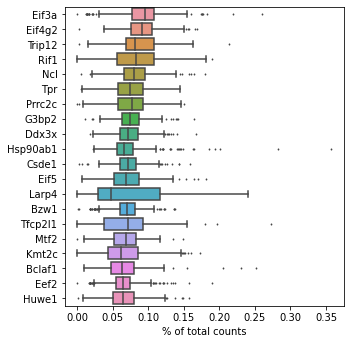

In [14]:
sc.pl.highest_expr_genes(deng_adata, n_top=20,)

In [15]:
deng_adata.var['mt'] = deng_adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(deng_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [16]:
p=0.95
deng_adata = deng_adata[deng_adata.obs.n_genes_by_counts < p* max(deng_adata.obs.n_genes_by_counts),:]
deng_adata = deng_adata[deng_adata.obs.pct_counts_mt <0.8,:]
deng_adata

View of AnnData object with n_obs × n_vars = 257 × 38198
    obs: 'annotation', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [17]:
sc.pp.normalize_total(deng_adata, target_sum=1e4)

/usr/local/lib/python3.7/dist-packages/scanpy/preprocessing/_normalization.py:155: UserWarning:

Revieved a view of an AnnData. Making a copy.



In [18]:
sc.pp.log1p(deng_adata)

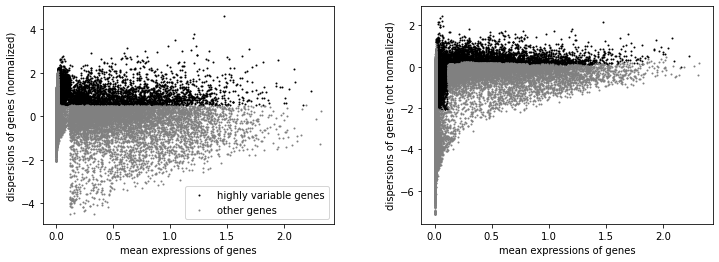

In [19]:
sc.pp.highly_variable_genes(deng_adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(deng_adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning:

The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.



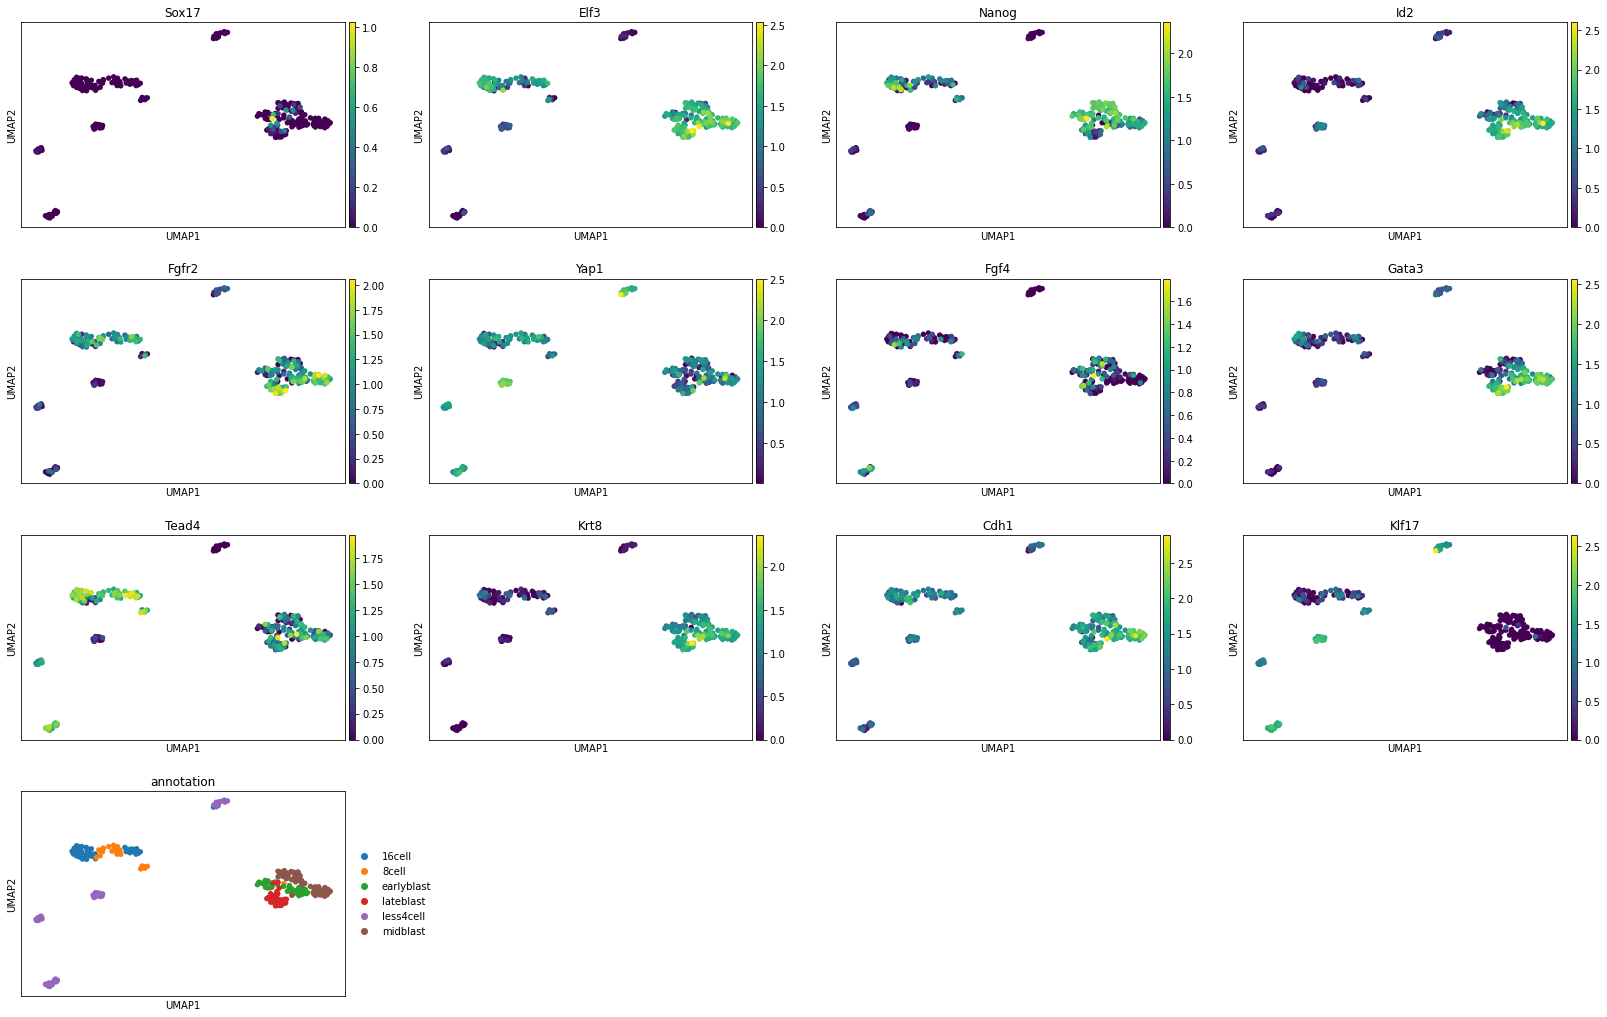

In [20]:
#Compute neighbourhood graph
sc.pp.neighbors(deng_adata, n_neighbors=10, n_pcs=4)
#Umap
sc.tl.umap(deng_adata)

#visualiza
sc.pl.umap(deng_adata, color=['Sox17', 'Elf3', 'Nanog', 'Id2', 'Fgfr2', 'Yap1', \
                            'Fgf4', 'Gata3', 'Tead4', 'Krt8', 'Cdh1', 'Klf17', 'annotation'], size = 120)

In [21]:
sc.pp.scale(deng_adata)

In [22]:
X = deng_adata.X.copy()
labels = deng_adata.obs['annotation'].values
encoder = LabelEncoder()
encoder.fit(labels)
y = encoder.transform(labels)

In [23]:
input_size = X.shape[1]

In [24]:
X.shape

(257, 38198)

# Set Up Models

## Train Smash Random Forest





In [ ]:
# needed for random forest Smash
!mkdir Figures

mkdir: cannot create directory ‘Figures’: File exists


 * Initialising ...

Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

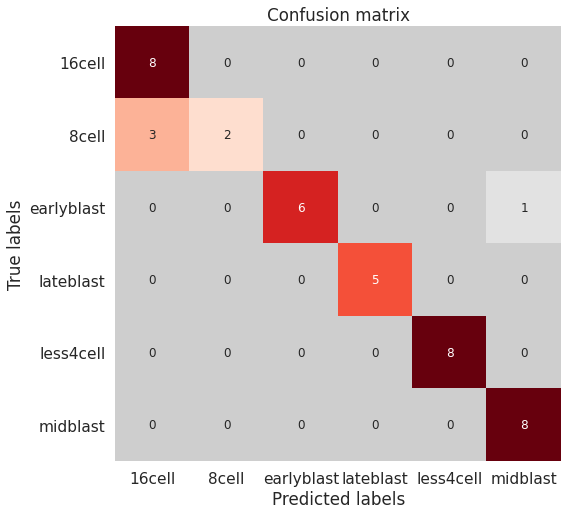

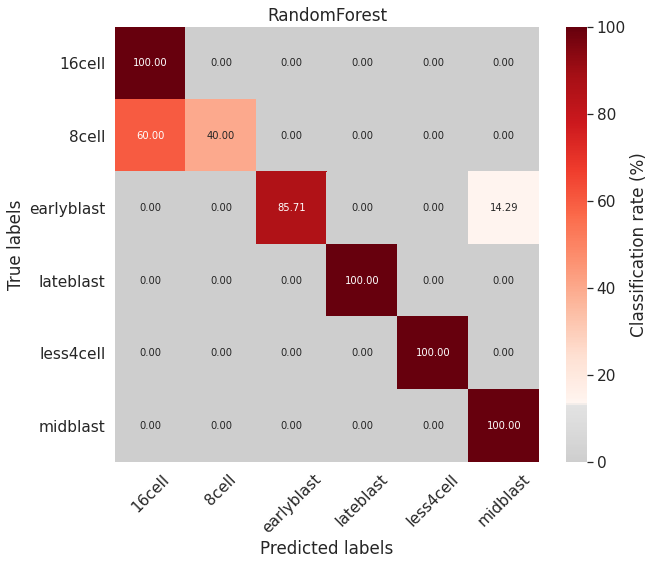

Accuracy: 0.9024390243902439: Misclassification: 0.09756097560975607
              precision    recall  f1-score   support

      16cell       0.73      1.00      0.84         8
       8cell       1.00      0.40      0.57         5
  earlyblast       1.00      0.86      0.92         7
   lateblast       1.00      1.00      1.00         5
   less4cell       1.00      1.00      1.00         8
    midblast       0.89      1.00      0.94         8

    accuracy                           0.90        41
   macro avg       0.94      0.88      0.88        41
weighted avg       0.93      0.90      0.89        41



/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



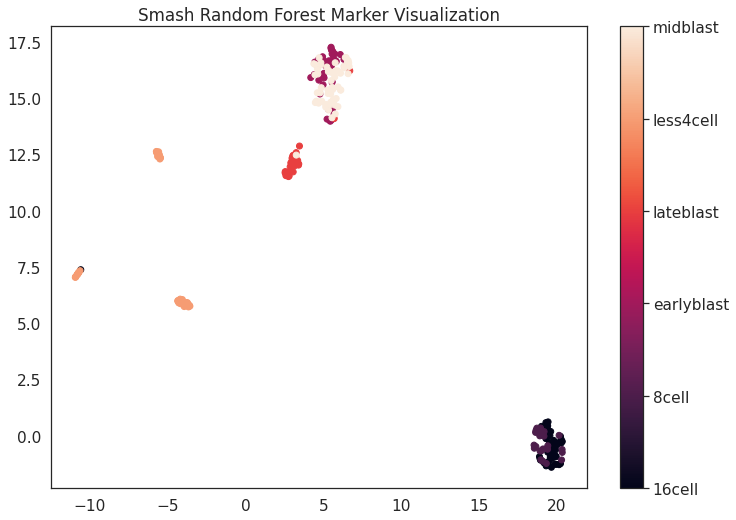

 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

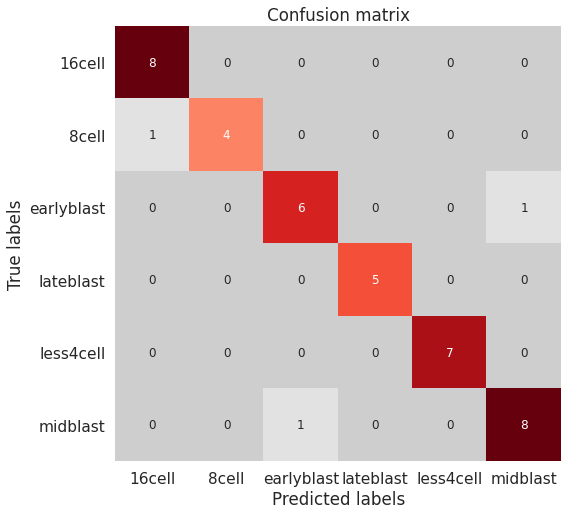

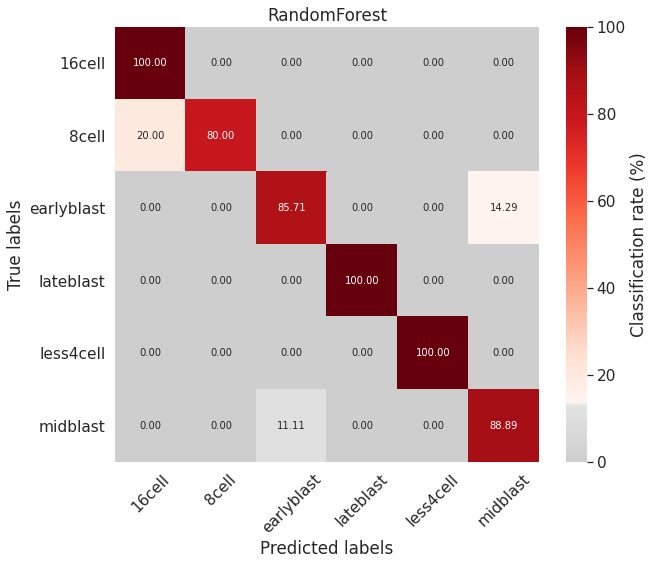

Accuracy: 0.926829268292683: Misclassification: 0.07317073170731703
              precision    recall  f1-score   support

      16cell       0.89      1.00      0.94         8
       8cell       1.00      0.80      0.89         5
  earlyblast       0.86      0.86      0.86         7
   lateblast       1.00      1.00      1.00         5
   less4cell       1.00      1.00      1.00         7
    midblast       0.89      0.89      0.89         9

    accuracy                           0.93        41
   macro avg       0.94      0.92      0.93        41
weighted avg       0.93      0.93      0.93        41



/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



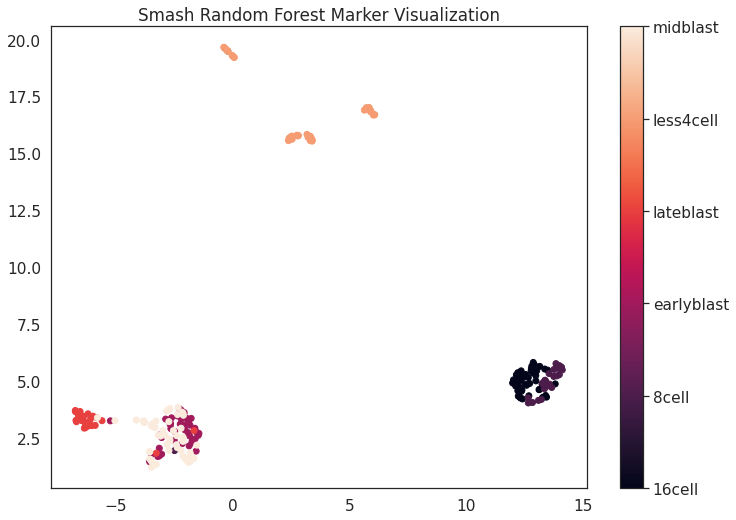

 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

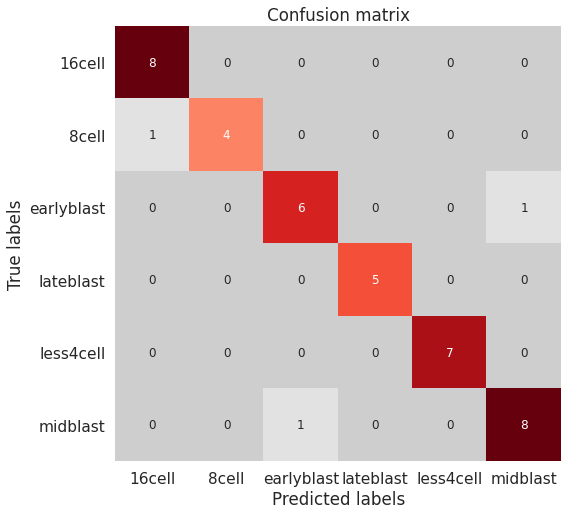

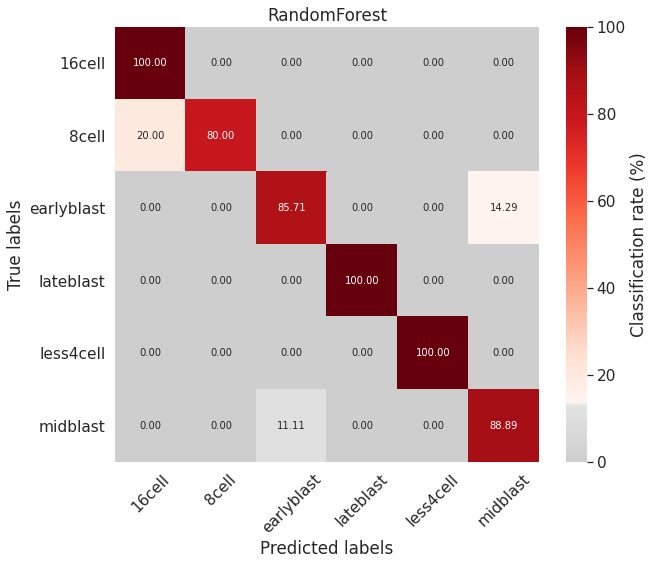

Accuracy: 0.926829268292683: Misclassification: 0.07317073170731703
              precision    recall  f1-score   support

      16cell       0.89      1.00      0.94         8
       8cell       1.00      0.80      0.89         5
  earlyblast       0.86      0.86      0.86         7
   lateblast       1.00      1.00      1.00         5
   less4cell       1.00      1.00      1.00         7
    midblast       0.89      0.89      0.89         9

    accuracy                           0.93        41
   macro avg       0.94      0.92      0.93        41
weighted avg       0.93      0.93      0.93        41



/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



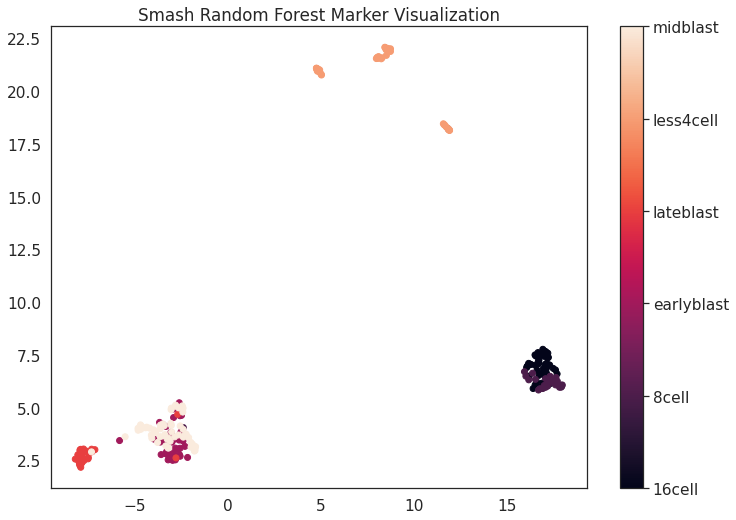

 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

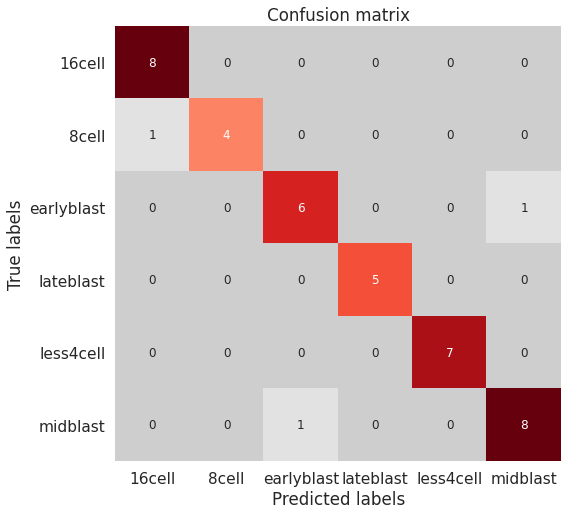

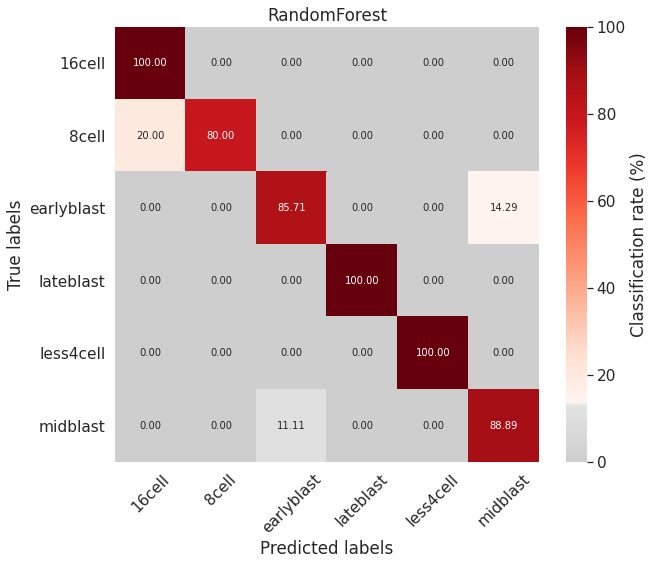

Accuracy: 0.926829268292683: Misclassification: 0.07317073170731703
              precision    recall  f1-score   support

      16cell       0.89      1.00      0.94         8
       8cell       1.00      0.80      0.89         5
  earlyblast       0.86      0.86      0.86         7
   lateblast       1.00      1.00      1.00         5
   less4cell       1.00      1.00      1.00         7
    midblast       0.89      0.89      0.89         9

    accuracy                           0.93        41
   macro avg       0.94      0.92      0.93        41
weighted avg       0.93      0.93      0.93        41



/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



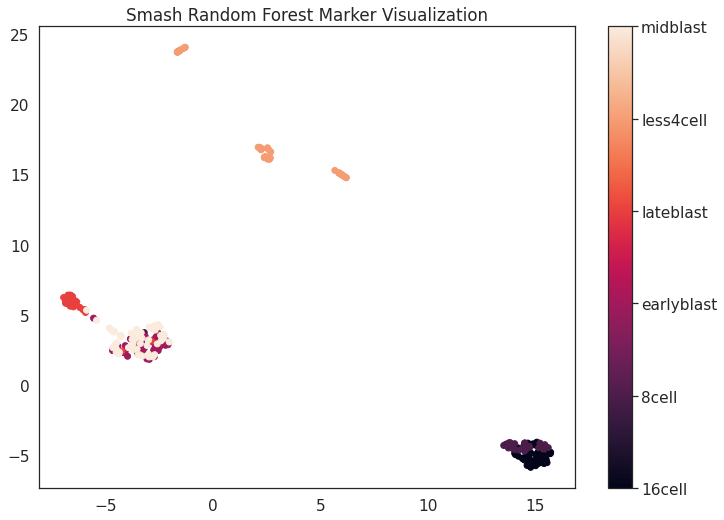

 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

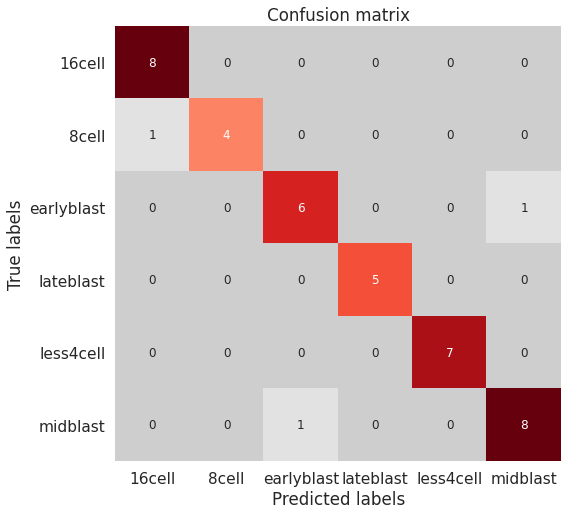

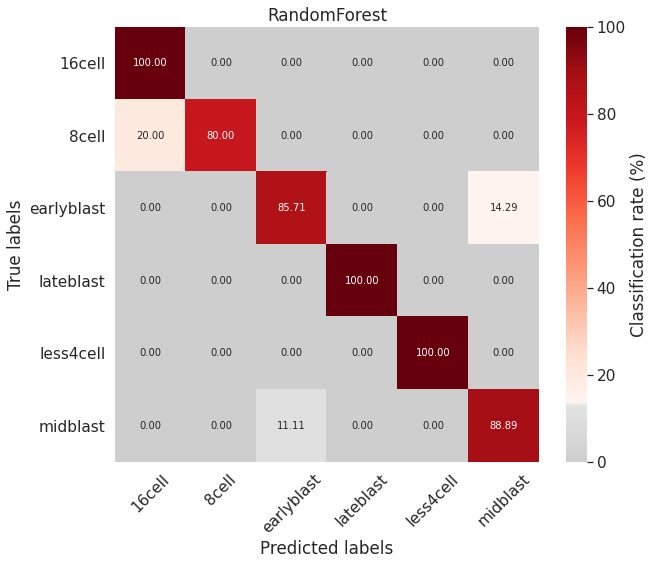

Accuracy: 0.926829268292683: Misclassification: 0.07317073170731703
              precision    recall  f1-score   support

      16cell       0.89      1.00      0.94         8
       8cell       1.00      0.80      0.89         5
  earlyblast       0.86      0.86      0.86         7
   lateblast       1.00      1.00      1.00         5
   less4cell       1.00      1.00      1.00         7
    midblast       0.89      0.89      0.89         9

    accuracy                           0.93        41
   macro avg       0.94      0.92      0.93        41
weighted avg       0.93      0.93      0.93        41



/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



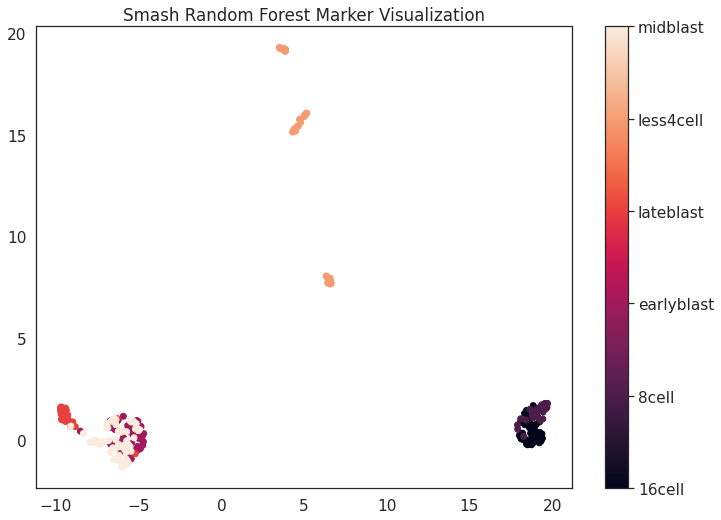

CPU times: user 40.3 s, sys: 3.79 s, total: 44 s
Wall time: 38.8 s


In [ ]:
%%time
for tryy in range(1,num_times+1):
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    train_X_y = deng_adata[np.concatenate([train_indices, val_indices]), :]
    sm = smashpy.smashpy()
    clf = sm.ensemble_learning(train_X_y, group_by="annotation", classifier="RandomForest", balance=True, verbose=True)
    selectedGenes, selectedGenes_dict = sm.gini_importance(train_X_y, clf, group_by="annotation", verbose=True, restrict_top=("global", k))
    # since this selects k per class, need select randomly from each classes
    smash_markers = deng_adata.var.index.get_indexer(selectedGenes)

    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = smash_markers)
    np.save(model_save_path + 'smash_rf_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'smash_rf_markers_{}.npy'.format(tryy), smash_markers)
    np.save(model_save_path + 'experiment_data_folds/smash_rf_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Smash Random Forest Marker Visualization', path = viz_save_path + 'smash_rf_markers_{}.png'.format(tryy), markers = smash_markers)

In [ ]:
results

(0.13461538461538458,
 {'0': {'f1-score': 0.8695652173913044,
   'precision': 0.7692307692307693,
   'recall': 1.0,
   'support': 10},
  '1': {'f1-score': 0.5714285714285715,
   'precision': 1.0,
   'recall': 0.4,
   'support': 5},
  '2': {'f1-score': 0.7777777777777778,
   'precision': 0.6363636363636364,
   'recall': 1.0,
   'support': 7},
  '3': {'f1-score': 0.888888888888889,
   'precision': 1.0,
   'recall': 0.8,
   'support': 5},
  '4': {'f1-score': 1.0, 'precision': 1.0, 'recall': 1.0, 'support': 10},
  '5': {'f1-score': 0.888888888888889,
   'precision': 1.0,
   'recall': 0.8,
   'support': 15},
  'accuracy': 0.8653846153846154,
  'macro avg': {'f1-score': 0.8327582240625718,
   'precision': 0.9009324009324008,
   'recall': 0.8333333333333334,
   'support': 52},
  'weighted avg': {'f1-score': 0.8610580241015025,
   'precision': 0.906670252824099,
   'recall': 0.8653846153846154,
   'support': 52}},
 array([[10,  0,  0,  0,  0,  0],
        [ 3,  2,  0,  0,  0,  0],
        [ 0,

## Train Smash DNN

the data is treated a bit differently than our other models

 * Initialising ...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                1222368   
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
activation (Activation)      (None, 32)                0         
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________________________________________________________________
activation_1 (Activation)    (None, 

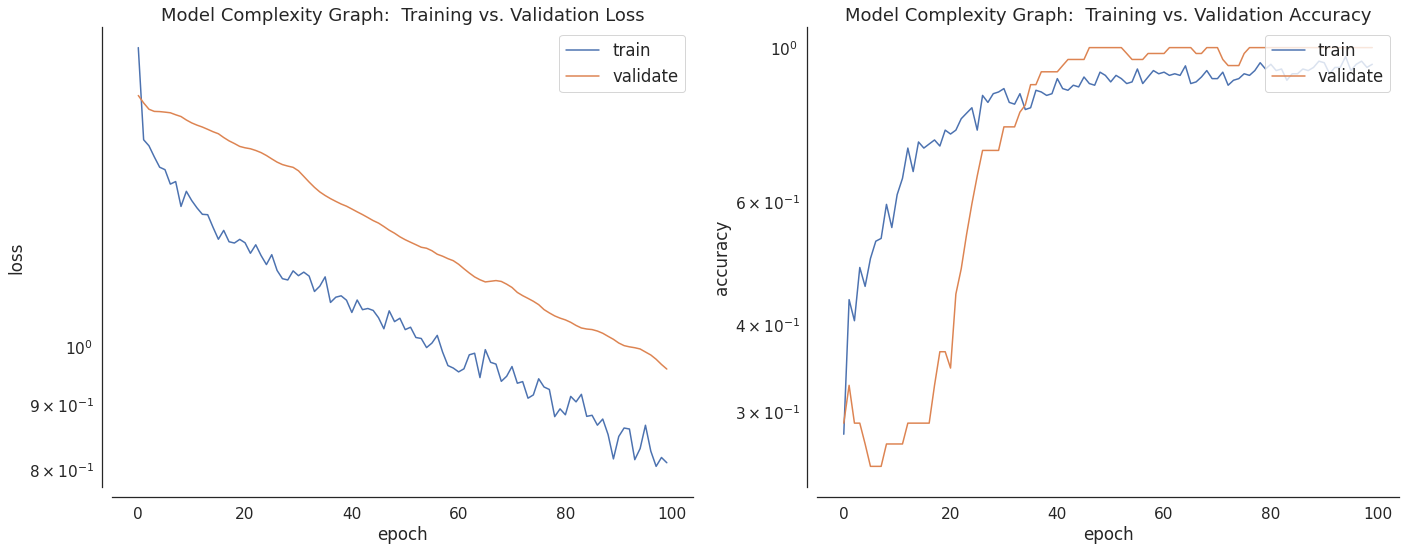

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning:

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).



<Figure size 432x288 with 0 Axes>

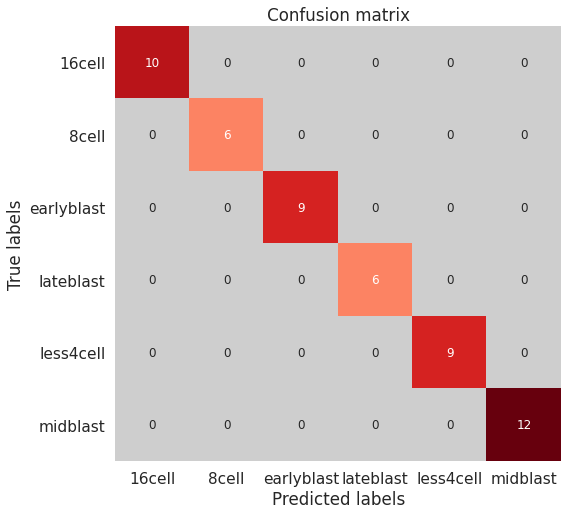

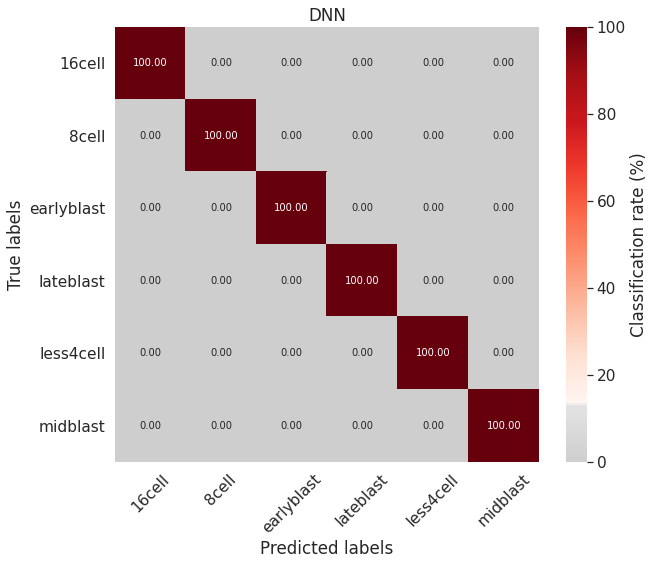

              precision    recall  f1-score   support

      16cell       1.00      1.00      1.00        10
       8cell       1.00      1.00      1.00         6
  earlyblast       1.00      1.00      1.00         9
   lateblast       1.00      1.00      1.00         6
   less4cell       1.00      1.00      1.00         9
    midblast       1.00      1.00      1.00        12

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52

2/2 [==============================] - 0s 9ms/step - loss: 0.9597 - accuracy: 1.0000 - auc: 0.9998 - precision: 1.0000 - recall: 0.1538


/usr/local/lib/python3.7/dist-packages/shap/explainers/_deep/deep_tf.py:91: UserWarning:

keras is no longer supported, please use tf.keras instead.

/usr/local/lib/python3.7/dist-packages/shap/explainers/_deep/deep_tf.py:96: UserWarning:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:435: UserWarning:

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.



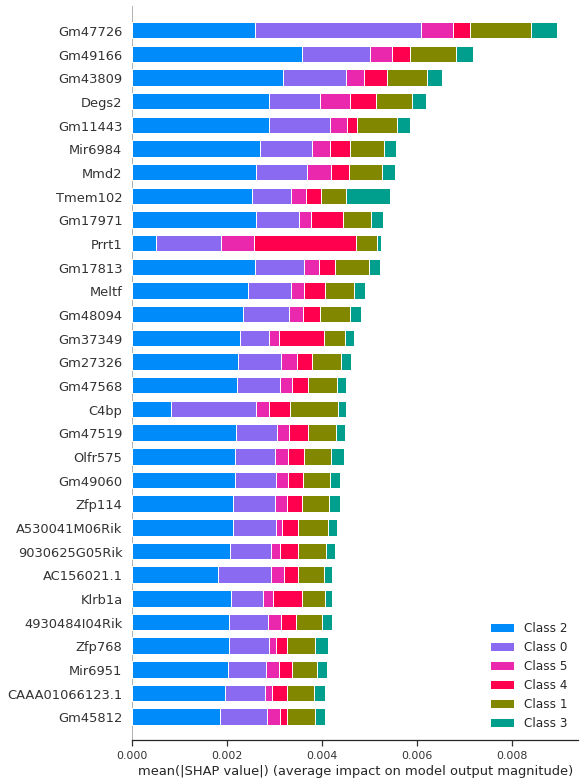

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



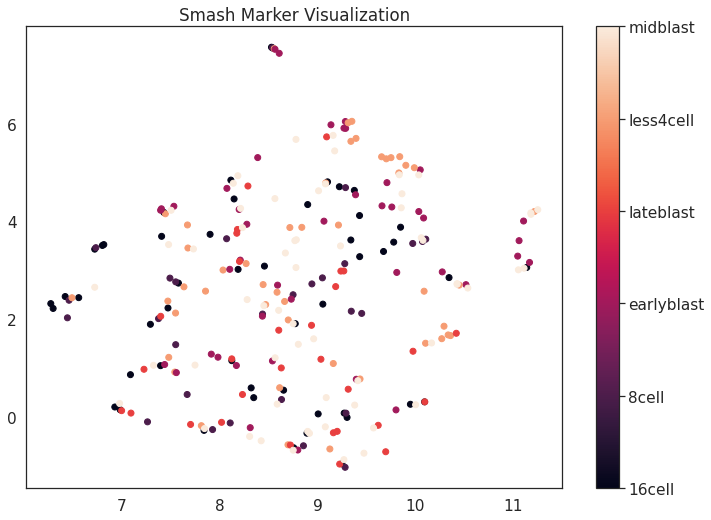

 * Initialising ...
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 32)                1222368   
_________________________________________________________________
batch_normalization_4 (Batch (None, 32)                128       
_________________________________________________________________
activation_4 (Activation)    (None, 32)                0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                528       
_________________________________________________________________
batch_normalization_5 (Batch (None, 16)                64        
_________________________________________________________________
activation_5 (Activation)    (None

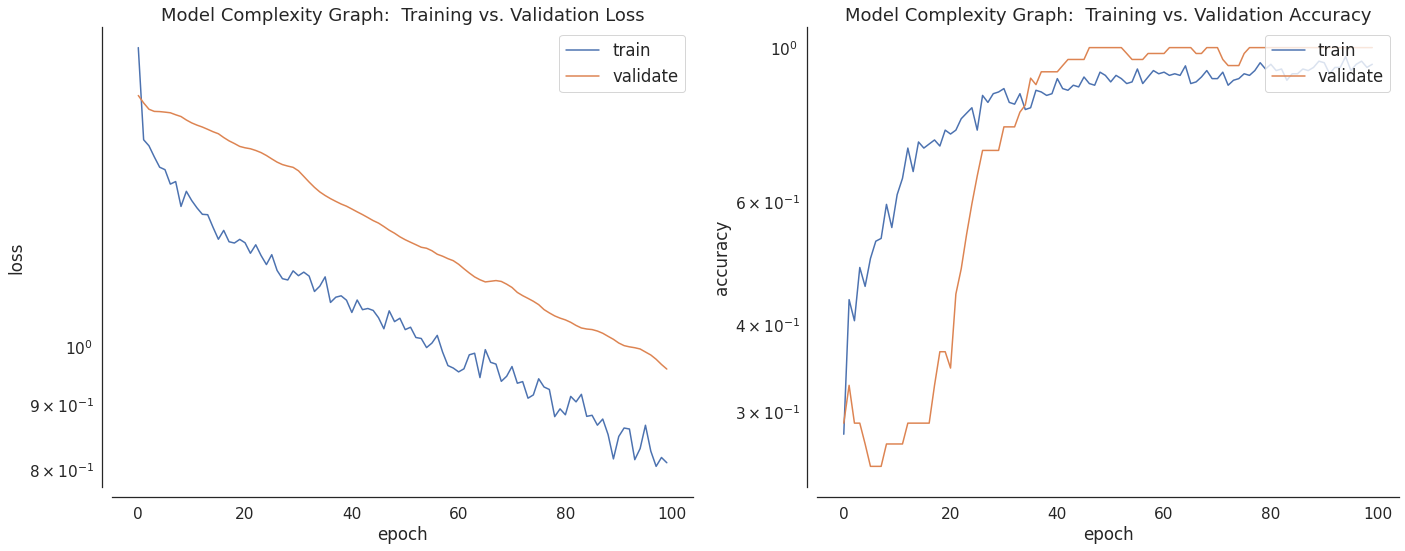

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning:

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).



<Figure size 432x288 with 0 Axes>

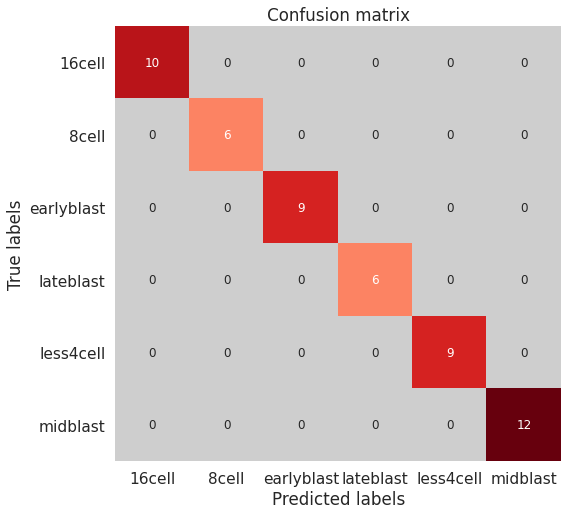

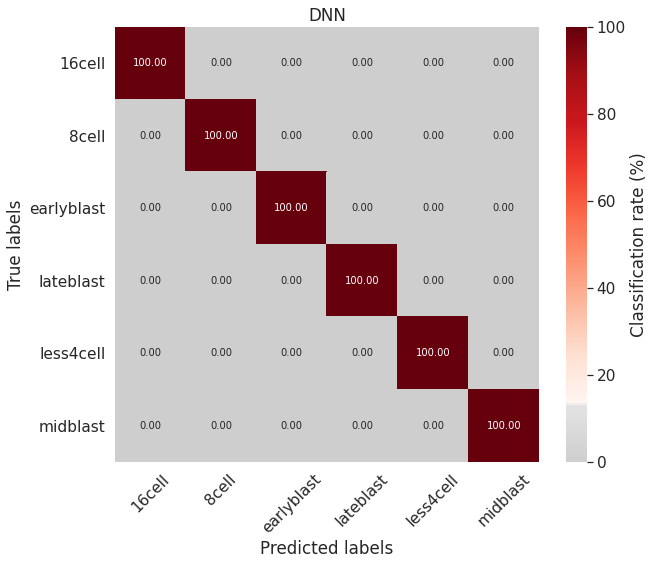

              precision    recall  f1-score   support

      16cell       1.00      1.00      1.00        10
       8cell       1.00      1.00      1.00         6
  earlyblast       1.00      1.00      1.00         9
   lateblast       1.00      1.00      1.00         6
   less4cell       1.00      1.00      1.00         9
    midblast       1.00      1.00      1.00        12

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52

2/2 [==============================] - 0s 10ms/step - loss: 0.9597 - accuracy: 1.0000 - auc: 0.9998 - precision: 1.0000 - recall: 0.1538


/usr/local/lib/python3.7/dist-packages/shap/explainers/_deep/deep_tf.py:96: UserWarning:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:435: UserWarning:

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.



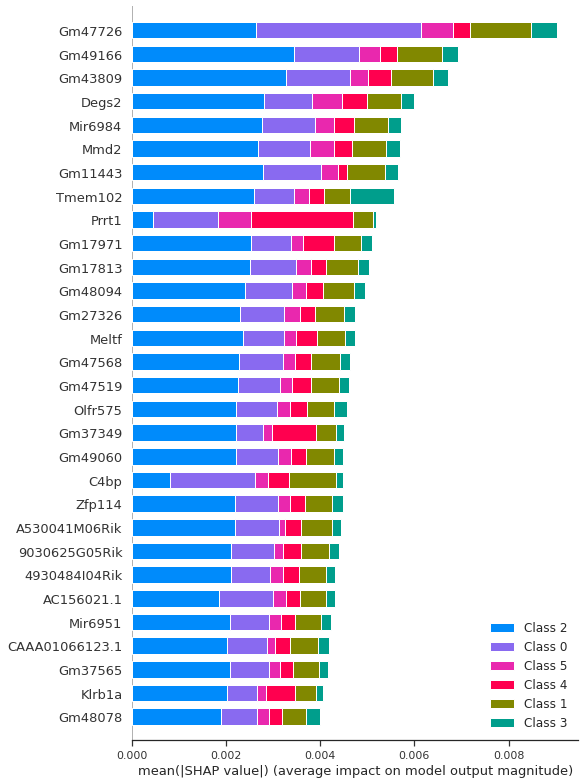

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



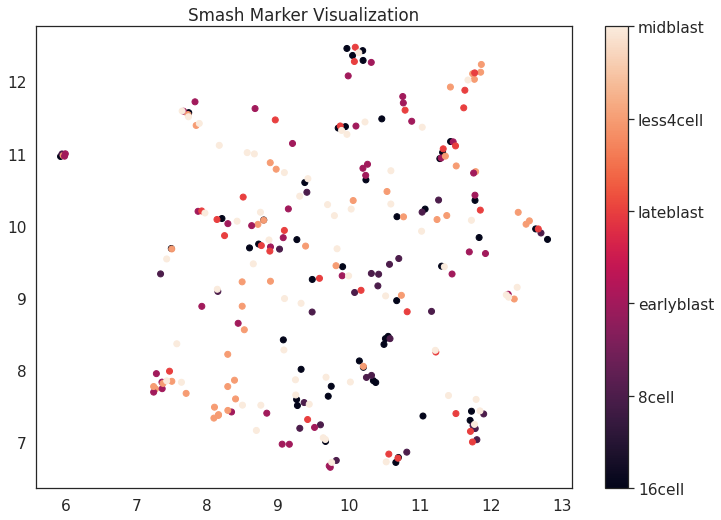

 * Initialising ...
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 32)                1222368   
_________________________________________________________________
batch_normalization_8 (Batch (None, 32)                128       
_________________________________________________________________
activation_8 (Activation)    (None, 32)                0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_9 (Batch (None, 16)                64        
_________________________________________________________________
activation_9 (Activation)    (None

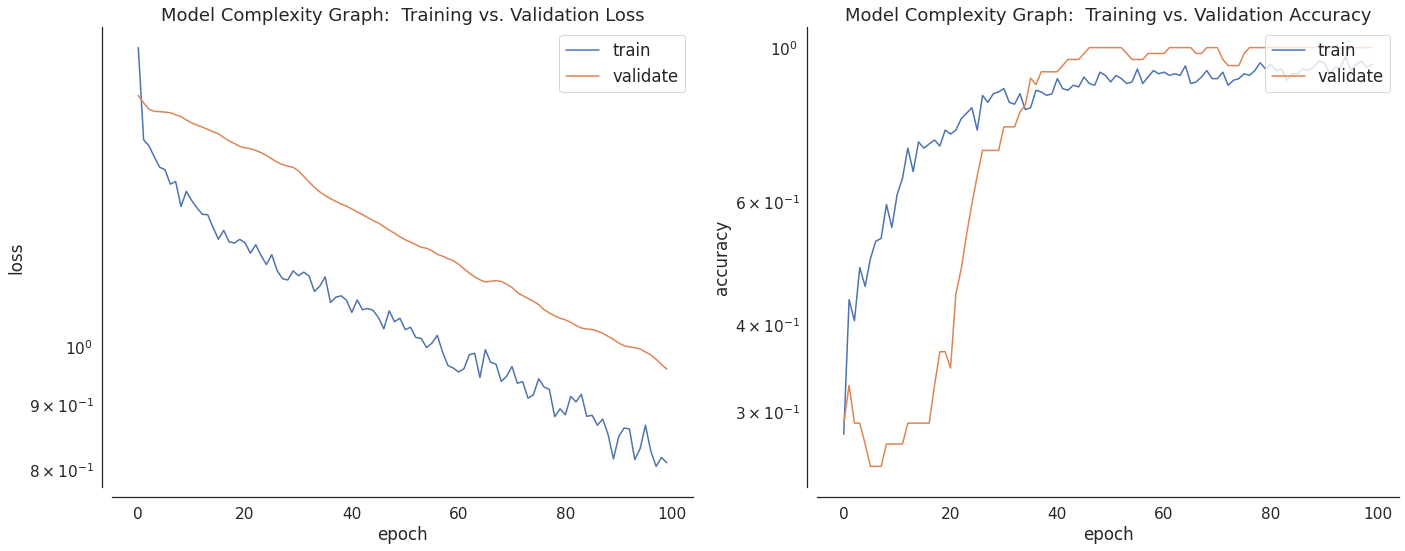

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning:

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).



<Figure size 432x288 with 0 Axes>

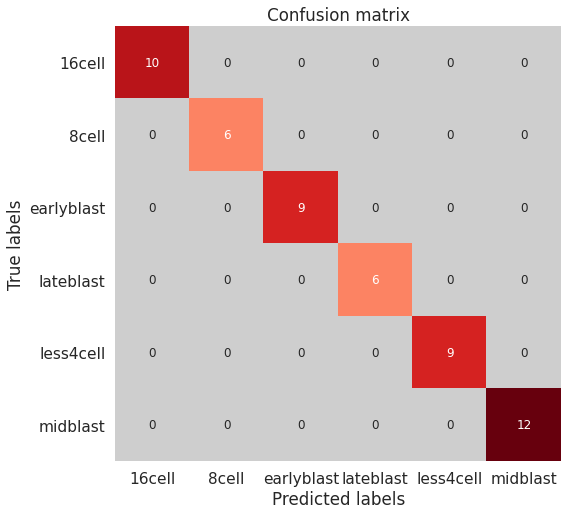

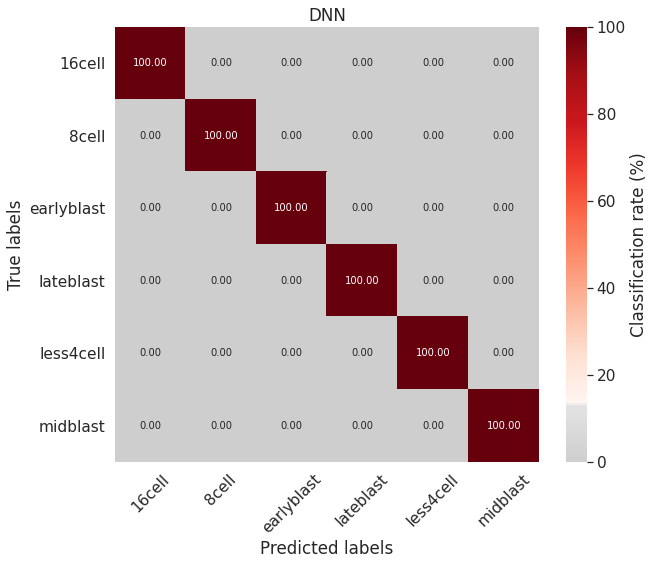

              precision    recall  f1-score   support

      16cell       1.00      1.00      1.00        10
       8cell       1.00      1.00      1.00         6
  earlyblast       1.00      1.00      1.00         9
   lateblast       1.00      1.00      1.00         6
   less4cell       1.00      1.00      1.00         9
    midblast       1.00      1.00      1.00        12

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52

2/2 [==============================] - 0s 9ms/step - loss: 0.9597 - accuracy: 1.0000 - auc: 0.9998 - precision: 1.0000 - recall: 0.1538


/usr/local/lib/python3.7/dist-packages/shap/explainers/_deep/deep_tf.py:96: UserWarning:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:435: UserWarning:

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.



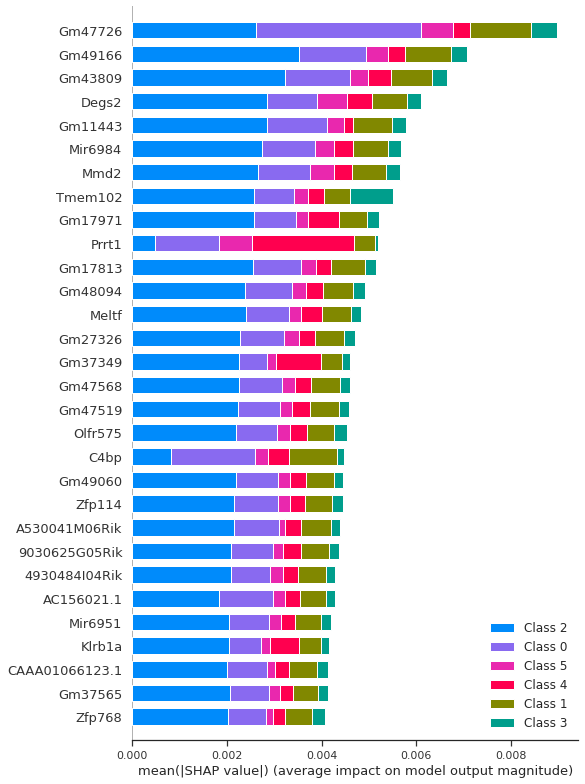

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



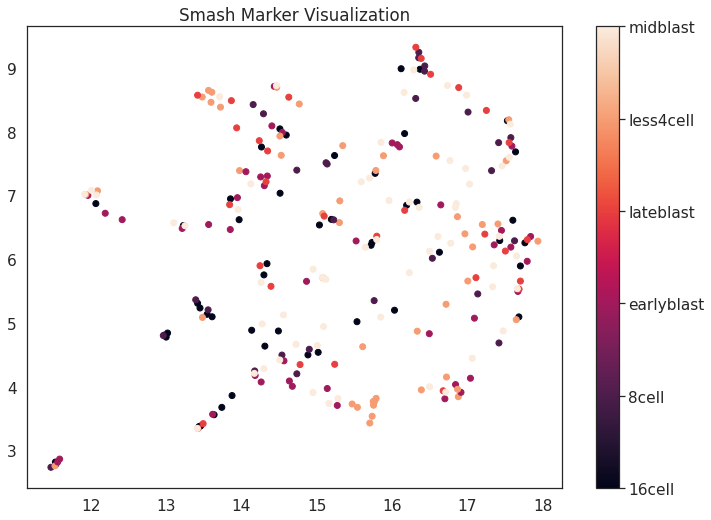

 * Initialising ...
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 32)                1222368   
_________________________________________________________________
batch_normalization_12 (Batc (None, 32)                128       
_________________________________________________________________
activation_12 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_13 (Batc (None, 16)                64        
_________________________________________________________________
activation_13 (Activation)   (None

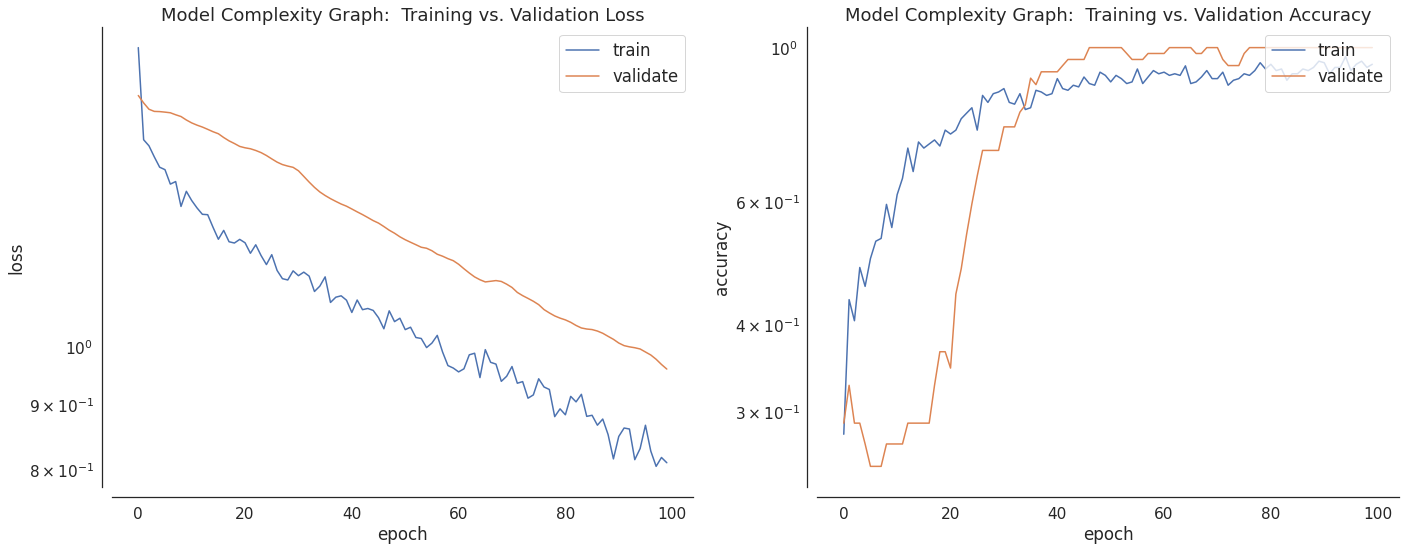

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning:

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).



<Figure size 432x288 with 0 Axes>

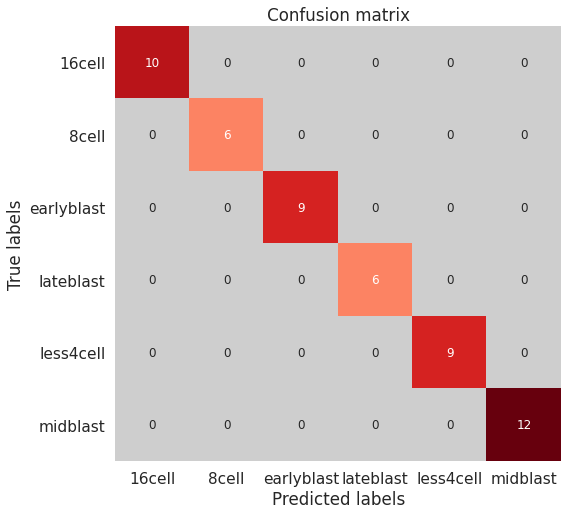

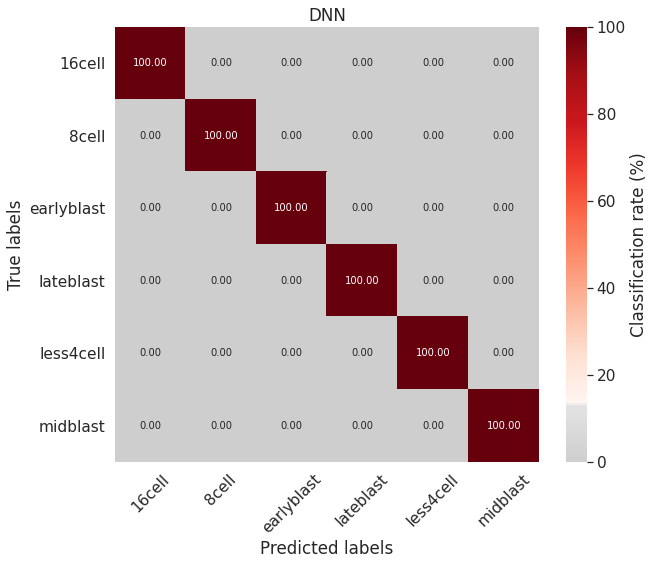

              precision    recall  f1-score   support

      16cell       1.00      1.00      1.00        10
       8cell       1.00      1.00      1.00         6
  earlyblast       1.00      1.00      1.00         9
   lateblast       1.00      1.00      1.00         6
   less4cell       1.00      1.00      1.00         9
    midblast       1.00      1.00      1.00        12

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52

2/2 [==============================] - 0s 12ms/step - loss: 0.9597 - accuracy: 1.0000 - auc: 0.9998 - precision: 1.0000 - recall: 0.1538


/usr/local/lib/python3.7/dist-packages/shap/explainers/_deep/deep_tf.py:96: UserWarning:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:435: UserWarning:

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.



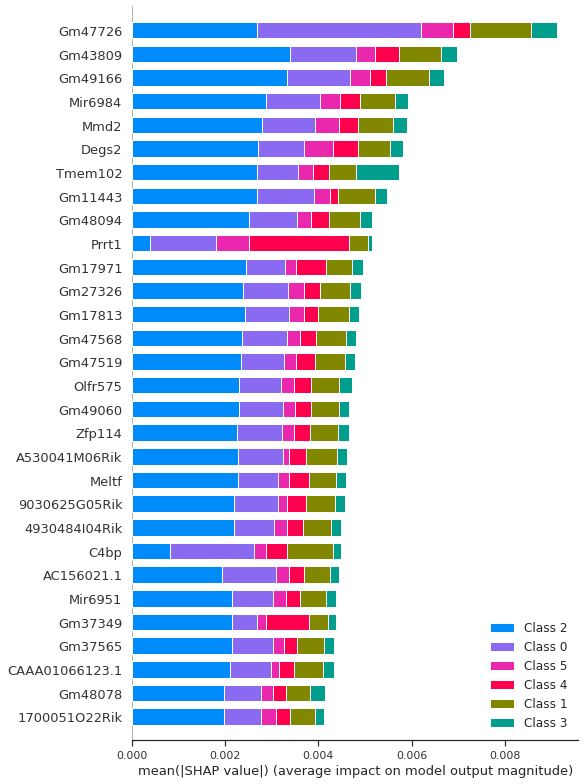

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



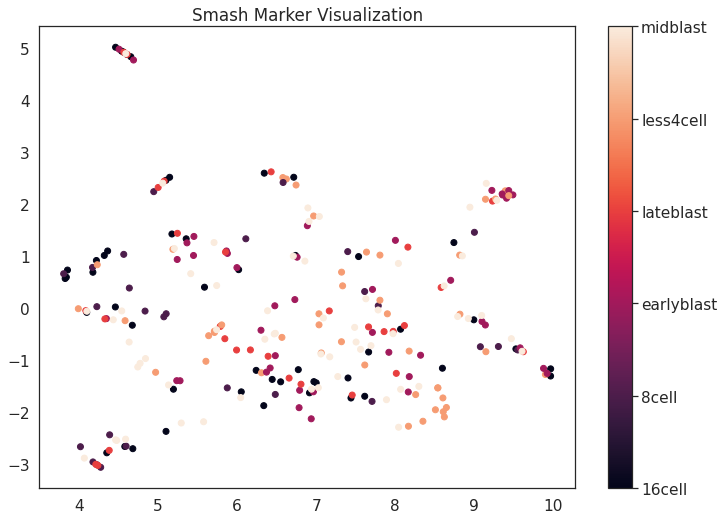

 * Initialising ...
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 32)                1222368   
_________________________________________________________________
batch_normalization_16 (Batc (None, 32)                128       
_________________________________________________________________
activation_16 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_17 (Batc (None, 16)                64        
_________________________________________________________________
activation_17 (Activation)   (None

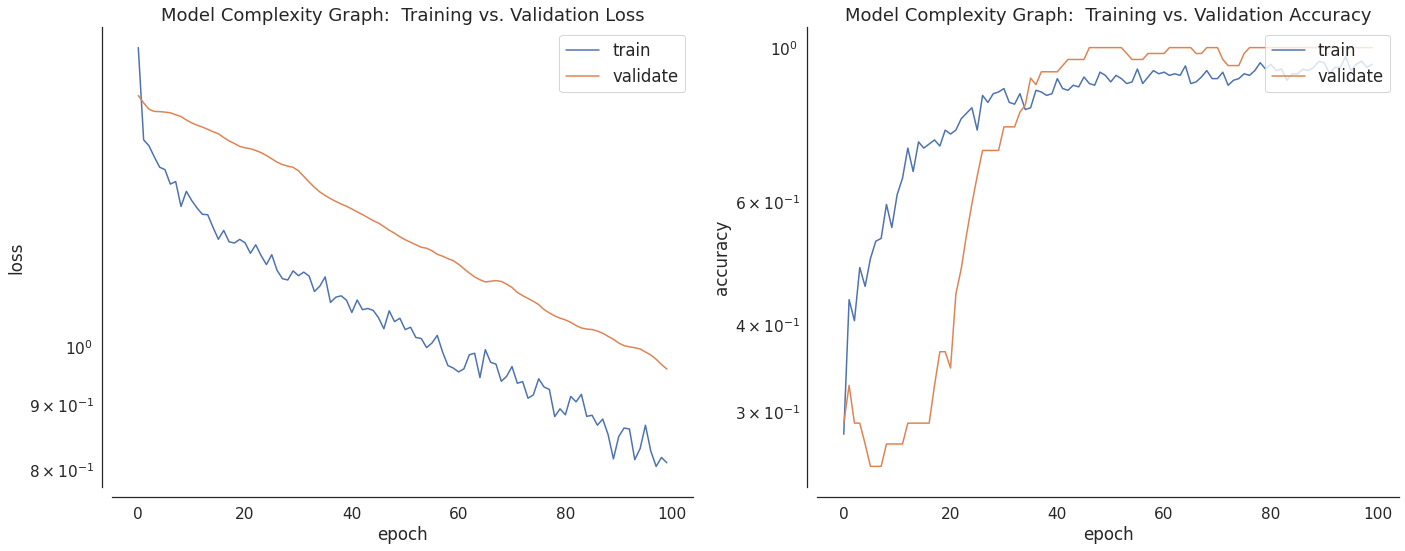

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning:

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).



<Figure size 432x288 with 0 Axes>

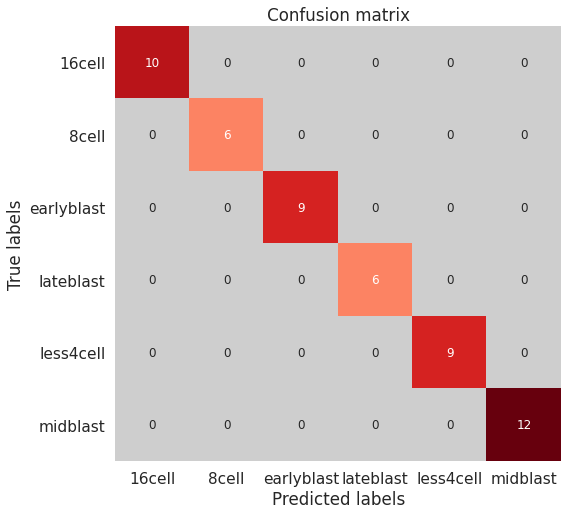

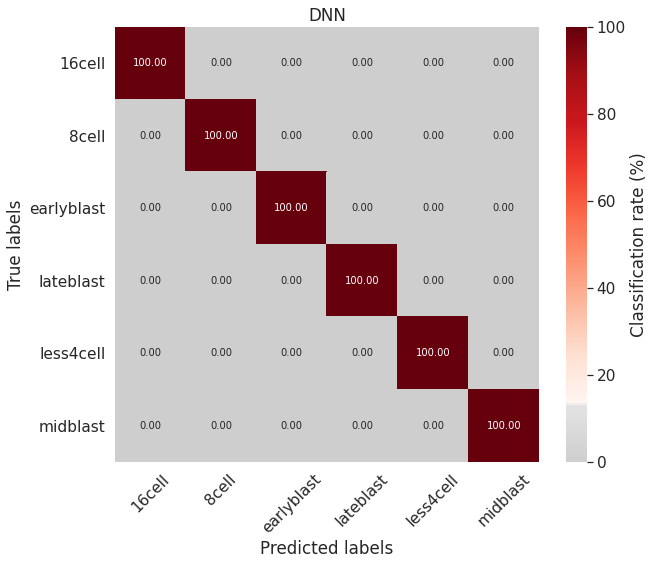

              precision    recall  f1-score   support

      16cell       1.00      1.00      1.00        10
       8cell       1.00      1.00      1.00         6
  earlyblast       1.00      1.00      1.00         9
   lateblast       1.00      1.00      1.00         6
   less4cell       1.00      1.00      1.00         9
    midblast       1.00      1.00      1.00        12

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52

2/2 [==============================] - 0s 9ms/step - loss: 0.9597 - accuracy: 1.0000 - auc: 0.9998 - precision: 1.0000 - recall: 0.1538


/usr/local/lib/python3.7/dist-packages/shap/explainers/_deep/deep_tf.py:96: UserWarning:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:435: UserWarning:

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.



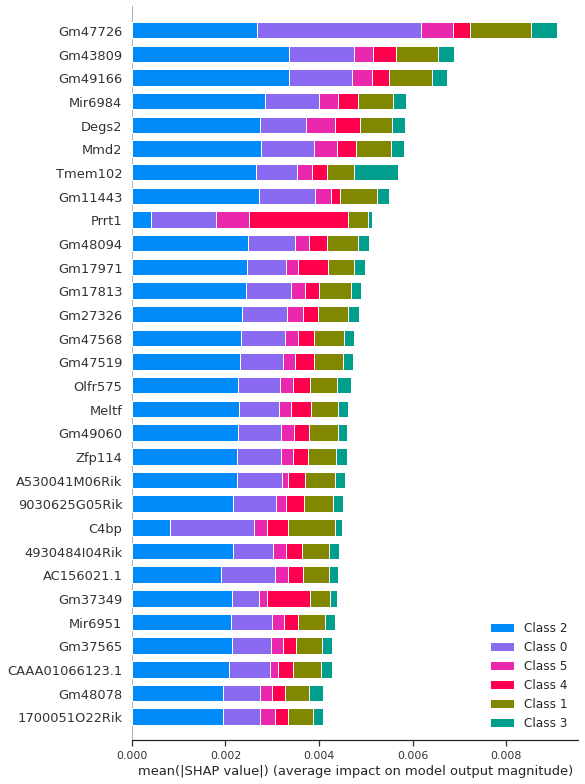

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



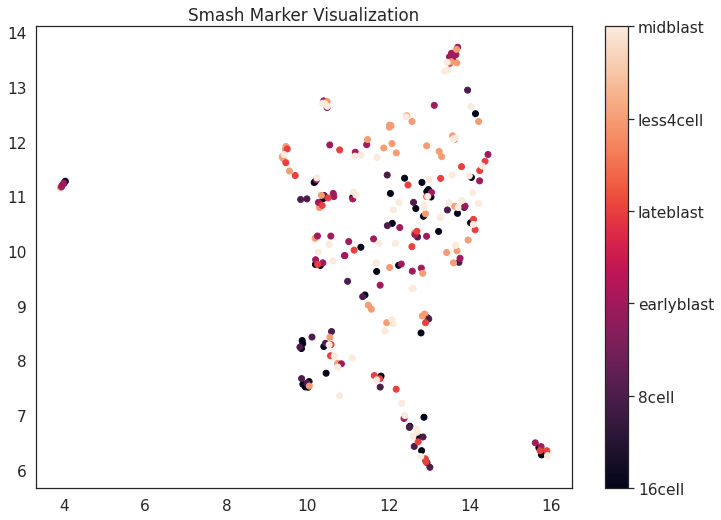

CPU times: user 2min 57s, sys: 25.5 s, total: 3min 22s
Wall time: 3min 45s


In [ ]:
%%time
for tryy in range(1,num_times+1):
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    train_X_y = deng_adata[np.concatenate([train_indices, val_indices]), :]
    sm = smashpy.smashpy()
    sm.DNN(deng_adata, group_by="annotation", model=None, balance=True, verbose=True, save=False)
    selectedGenes, selectedGenes_dict = sm.run_shap(deng_adata, group_by="annotation", model=None, verbose=True, pct=0.1, restrict_top=("global", k))
    # since this selects k per class, need select randomly from each classes
    smash_markers = deng_adata.var.index.get_indexer(selectedGenes)

    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = smash_markers)
    np.save(model_save_path + 'smash_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'smash_markers_{}.npy'.format(tryy), smash_markers)
    np.save(model_save_path + 'experiment_data_folds/smash_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Smash Marker Visualization', path = viz_save_path + 'smash_markers_{}.png'.format(tryy), markers = smash_markers)

Names are different than in the example notebook but things like
ENSMUSG00000062209 correspond to Erbb4.

In [ ]:
results

(0.5769230769230769,
 {'0': {'f1-score': 0.5454545454545454,
   'precision': 0.5,
   'recall': 0.6,
   'support': 10},
  '1': {'f1-score': 0.22222222222222224,
   'precision': 0.25,
   'recall': 0.2,
   'support': 5},
  '2': {'f1-score': 0.2,
   'precision': 0.3333333333333333,
   'recall': 0.14285714285714285,
   'support': 7},
  '3': {'f1-score': 0.22222222222222224,
   'precision': 0.25,
   'recall': 0.2,
   'support': 5},
  '4': {'f1-score': 0.6666666666666666,
   'precision': 0.6363636363636364,
   'recall': 0.7,
   'support': 10},
  '5': {'f1-score': 0.3636363636363636,
   'precision': 0.3333333333333333,
   'recall': 0.4,
   'support': 15},
  'accuracy': 0.4230769230769231,
  'macro avg': {'f1-score': 0.3700336700336701,
   'precision': 0.38383838383838387,
   'recall': 0.3738095238095238,
   'support': 52},
  'weighted avg': {'f1-score': 0.4076534576534577,
   'precision': 0.4076340326340326,
   'recall': 0.4230769230769231,
   'support': 52}},
 array([[6, 1, 0, 0, 0, 3],
     

## Train RankCorr

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



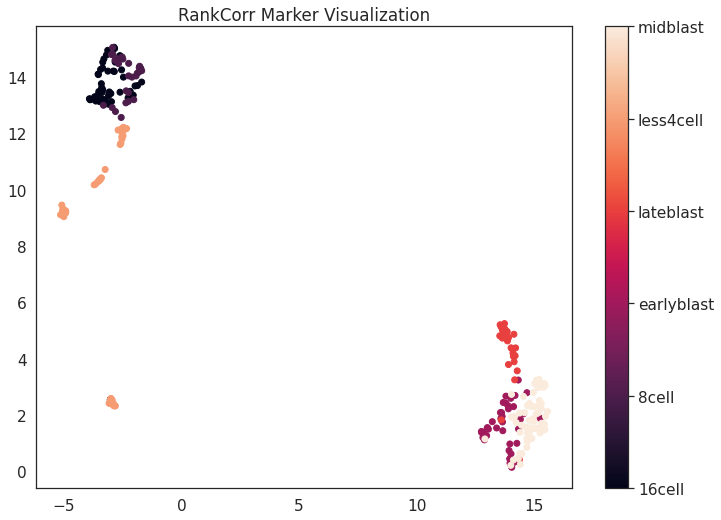

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



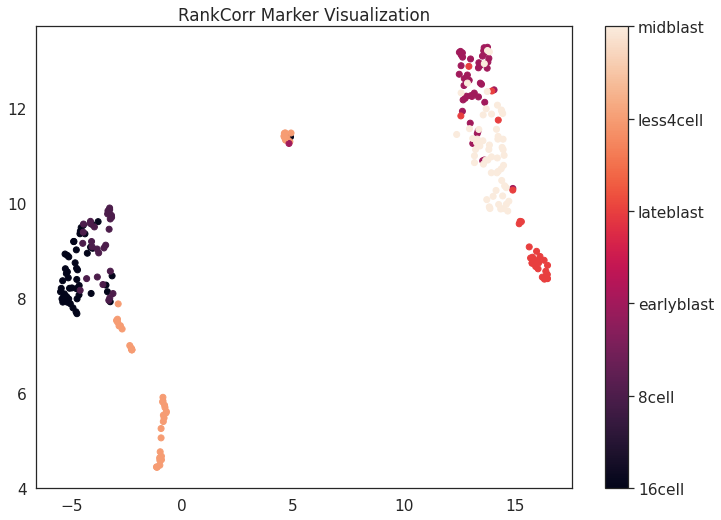

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



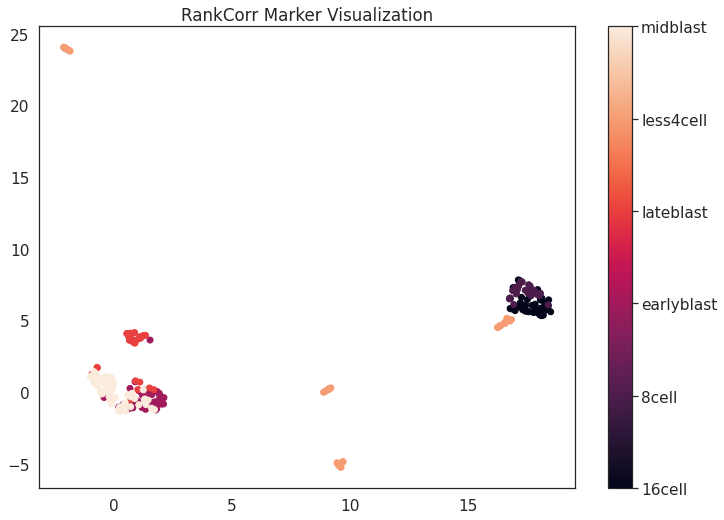

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



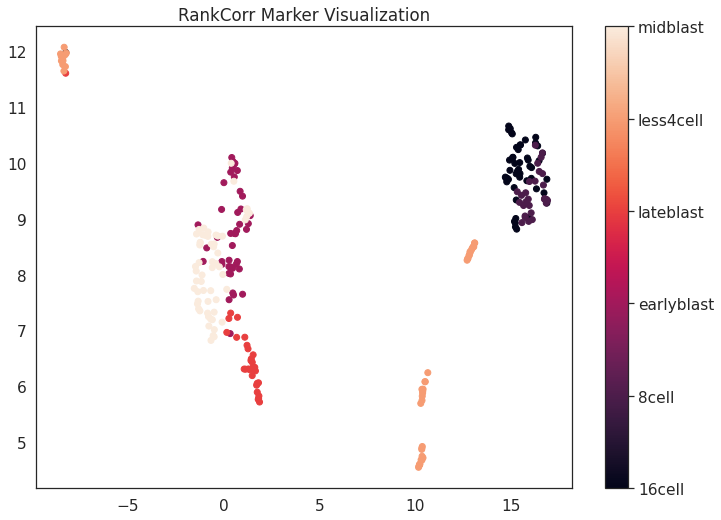

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



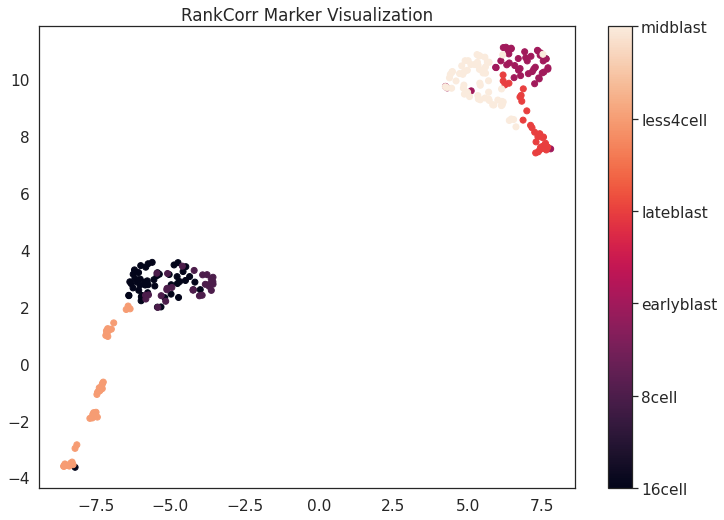

In [ ]:
for tryy in range(1,num_times+1):
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    data = Rocks(X_train, y_train)
    lamb = 5.5# this can be whatever

    rankcorr_markers = data.CSrankMarkers(lamb=lamb, writeOut=False, keepZeros=False, onlyNonZero=False)
    if len(rankcorr_markers) < k:
        raise Exception("Increase lamb for rank corr procedure")
    if len(rankcorr_markers) > k:
        rankcorr_markers = rankcorr_markers[:k]
    geneNames = np.array(deng_adata.var.index)
    data.genes = geneNames
    marker_genes = data.markers_to_genes(rankcorr_markers)
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = rankcorr_markers)
    np.save(model_save_path + 'rankcorr_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'rankcorr_markers_{}.npy'.format(tryy), rankcorr_markers)
    np.save(model_save_path + 'experiment_data_folds/rankcorr_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'RankCorr Marker Visualization', path = viz_save_path + 'rankcorr_markers_{}.png'.format(tryy), markers = rankcorr_markers)

In [ ]:
len(rankcorr_markers)

50

In [ ]:
print("Some, if not all, selected gene names")
print(marker_genes)

Some, if not all, selected gene names
['Cul5', 'Slc22a4', 'Cthrc1', 'Gm26448', 'Acadvl', 'Ngef', 'Gm7132', 'Rpl36-ps8', 'Alpl', 'Gm45448', 'Gm50147', 'Obox3-ps1', 'Cox20', 'Hcrt', 'Obox3-ps2', 'Obox3-ps4', 'Scd2', 'Sqstm1', 'Obox3-ps5', 'Gm6507', '4930471L23Rik', 'Rusc1', 'Obox3-ps6', 'Rprl3', 'Smpdl3b', 'Cdk2ap1', 'Gsta1', 'Gpd1l', 'Lin37', 'Gm3776', 'Tmem231', 'BC051665', 'Abhd14b', 'Ctsll3', 'Adck5', 'Gm4819', 'Fabp5', 'Isx', 'Larp4', 'Cldn3', 'Tex11', 'Add1', 'Rpl3', 'Foxe1', 'Lbx2', 'Nanog-ps1', 'Lig1', 'Tmem256', 'Gm2467', 'Gm35248']


In [ ]:
results

(0.17307692307692313,
 {'0': {'f1-score': 0.9333333333333333,
   'precision': 0.875,
   'recall': 1.0,
   'support': 14},
  '1': {'f1-score': 0.6666666666666666,
   'precision': 1.0,
   'recall': 0.5,
   'support': 6},
  '2': {'f1-score': 0.7272727272727273,
   'precision': 0.5714285714285714,
   'recall': 1.0,
   'support': 8},
  '3': {'f1-score': 0.8571428571428571,
   'precision': 0.8571428571428571,
   'recall': 0.8571428571428571,
   'support': 7},
  '4': {'f1-score': 1.0, 'precision': 1.0, 'recall': 1.0, 'support': 6},
  '5': {'f1-score': 0.7058823529411764,
   'precision': 1.0,
   'recall': 0.5454545454545454,
   'support': 11},
  'accuracy': 0.8269230769230769,
  'macro avg': {'f1-score': 0.8150496562261268,
   'precision': 0.8839285714285715,
   'recall': 0.8170995670995671,
   'support': 52},
  'weighted avg': {'f1-score': 0.8201837378307967,
   'precision': 0.8811813186813187,
   'recall': 0.8269230769230769,
   'support': 52}},
 array([[14,  0,  0,  0,  0,  0],
        [ 2,

## Train L1 VAE

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning:

you defined a validation_step but have no val_dataloader. Skipping val loop

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | encoder    | Sequential | 20.1 M
1 | enc_mean   | Linear     | 65.7 K
2 | enc_logvar | Linear     | 65.7 K
3 | decoder    | Sequential | 19.7 M
4 | dec_logvar | Sequential | 19.7 M
------------------------------------------
59.6 M    Trainable params
0         Non-trainable params
59.6 M    Total params
238.320   Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning:

Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate

Restored states from the checkpoint file at /content/lr_find_temp_model.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | encoder    | Sequential | 20.1 M
1 | enc_mean   | Linear     | 65.7 K
2 | enc_logvar | Linear     | 65.7 K
3 | decoder    | Sequential | 19.7 M
4 | dec_logvar | Sequential | 19.7 M
------------------------------------------
59.6 M    Trainable params
0         Non-trainable params
59.6 M    Total params
238.320   Total estimated m

New Learning Rate 1.1220184543019633e-06



/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



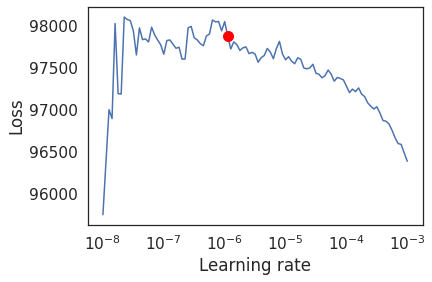

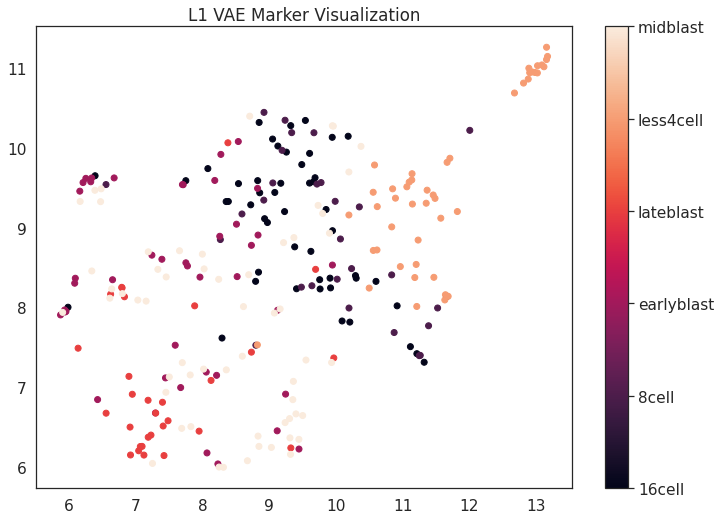

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning:

you defined a validation_step but have no val_dataloader. Skipping val loop

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | encoder    | Sequential | 20.1 M
1 | enc_mean   | Linear     | 65.7 K
2 | enc_logvar | Linear     | 65.7 K
3 | decoder    | Sequential | 19.7 M
4 | dec_logvar | Sequential | 19.7 M
------------------------------------------
59.6 M    Trainable params
0         Non-trainable params
59.6 M    Total params
238.320   Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning:

Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate

Restored states from the checkpoint file at /content/lr_find_temp_model.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | encoder    | Sequential | 20.1 M
1 | enc_mean   | Linear     | 65.7 K
2 | enc_logvar | Linear     | 65.7 K
3 | decoder    | Sequential | 19.7 M
4 | dec_logvar | Sequential | 19.7 M
------------------------------------------
59.6 M    Trainable params
0         Non-trainable params
59.6 M    Total params
238.320   Total estimated m

New Learning Rate 3.5481338923357545e-08


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



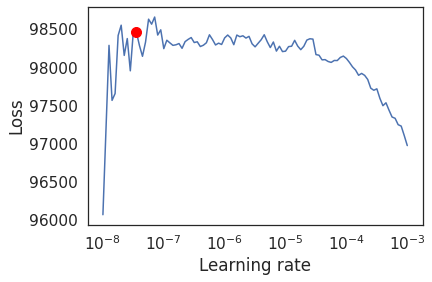

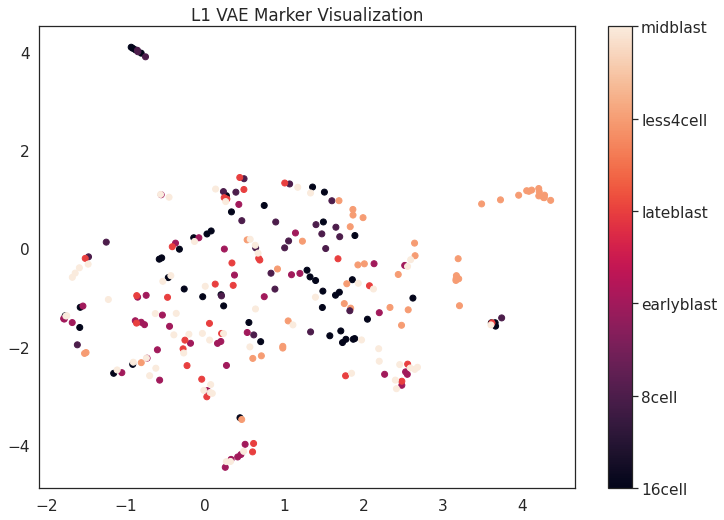

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning:

you defined a validation_step but have no val_dataloader. Skipping val loop

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | encoder    | Sequential | 20.1 M
1 | enc_mean   | Linear     | 65.7 K
2 | enc_logvar | Linear     | 65.7 K
3 | decoder    | Sequential | 19.7 M
4 | dec_logvar | Sequential | 19.7 M
------------------------------------------
59.6 M    Trainable params
0         Non-trainable params
59.6 M    Total params
238.320   Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning:

Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate

Restored states from the checkpoint file at /content/lr_find_temp_model.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | encoder    | Sequential | 20.1 M
1 | enc_mean   | Linear     | 65.7 K
2 | enc_logvar | Linear     | 65.7 K
3 | decoder    | Sequential | 19.7 M
4 | dec_logvar | Sequential | 19.7 M
------------------------------------------
59.6 M    Trainable params
0         Non-trainable params
59.6 M    Total params
238.320   Total estimated m

New Learning Rate 2.511886431509581e-07


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



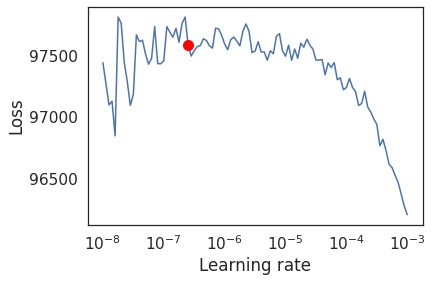

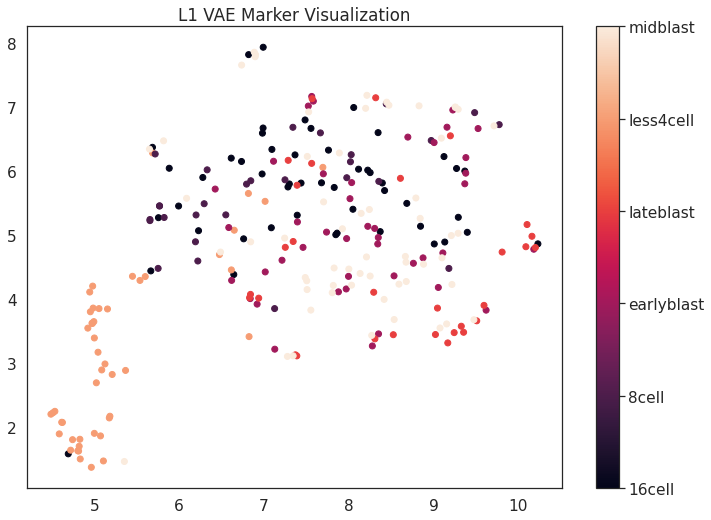

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning:

you defined a validation_step but have no val_dataloader. Skipping val loop

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | encoder    | Sequential | 20.1 M
1 | enc_mean   | Linear     | 65.7 K
2 | enc_logvar | Linear     | 65.7 K
3 | decoder    | Sequential | 19.7 M
4 | dec_logvar | Sequential | 19.7 M
------------------------------------------
59.6 M    Trainable params
0         Non-trainable params
59.6 M    Total params
238.320   Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning:

Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate

Restored states from the checkpoint file at /content/lr_find_temp_model.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | encoder    | Sequential | 20.1 M
1 | enc_mean   | Linear     | 65.7 K
2 | enc_logvar | Linear     | 65.7 K
3 | decoder    | Sequential | 19.7 M
4 | dec_logvar | Sequential | 19.7 M
------------------------------------------
59.6 M    Trainable params
0         Non-trainable params
59.6 M    Total params
238.320   Total estimated m

New Learning Rate 7.079457843841379e-07


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



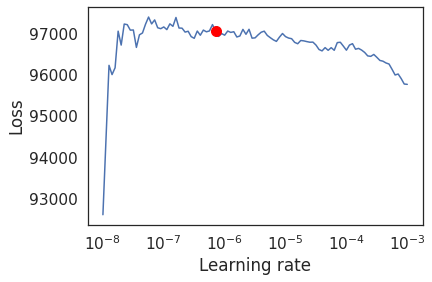

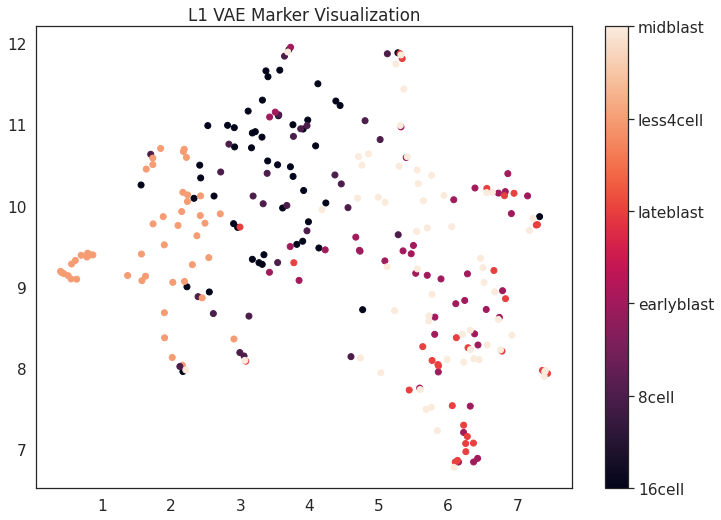

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning:

you defined a validation_step but have no val_dataloader. Skipping val loop

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | encoder    | Sequential | 20.1 M
1 | enc_mean   | Linear     | 65.7 K
2 | enc_logvar | Linear     | 65.7 K
3 | decoder    | Sequential | 19.7 M
4 | dec_logvar | Sequential | 19.7 M
------------------------------------------
59.6 M    Trainable params
0         Non-trainable params
59.6 M    Total params
238.320   Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning:

Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate

Restored states from the checkpoint file at /content/lr_find_temp_model.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | encoder    | Sequential | 20.1 M
1 | enc_mean   | Linear     | 65.7 K
2 | enc_logvar | Linear     | 65.7 K
3 | decoder    | Sequential | 19.7 M
4 | dec_logvar | Sequential | 19.7 M
------------------------------------------
59.6 M    Trainable params
0         Non-trainable params
59.6 M    Total params
238.320   Total estimated m

New Learning Rate 0.000501187233627272


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



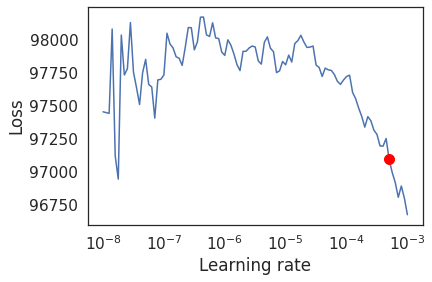

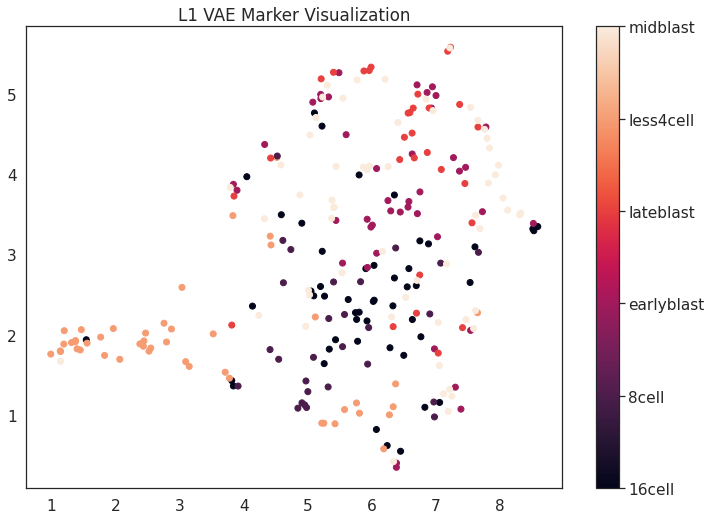

In [ ]:
feature_std = torch.tensor(X).std(dim = 0)
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.8, 0.0, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    model = VAE_l1_diag(input_size, hidden_layer_size, z_size, batch_norm = batch_norm)
    tmp_path = model_save_path + 'l1_vae_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    val_dataloader = None
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, min_epochs = min_epochs, 
                     max_epochs = max_epochs, auto_lr = True, early_stopping_patience = 4, precision = 16)
    l1_markers = model.markers(feature_std = feature_std.to(model.device), k = k).clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = l1_markers)
    np.save(model_save_path + 'l1_vae_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'l1_vae_markers_{}.npy'.format(tryy), l1_markers)
    np.save(model_save_path + 'experiment_data_folds/l1_vae_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'L1 VAE Marker Visualization', path = viz_save_path + 'l1_vae_markers_{}.png'.format(tryy), markers = l1_markers)

In [ ]:
results

(0.3076923076923077,
 {'0': {'f1-score': 0.6666666666666666,
   'precision': 0.5714285714285714,
   'recall': 0.8,
   'support': 10},
  '1': {'f1-score': 0.4, 'precision': 1.0, 'recall': 0.25, 'support': 4},
  '2': {'f1-score': 0.7000000000000001,
   'precision': 0.7777777777777778,
   'recall': 0.6363636363636364,
   'support': 11},
  '3': {'f1-score': 0.3333333333333333,
   'precision': 0.3333333333333333,
   'recall': 0.3333333333333333,
   'support': 3},
  '4': {'f1-score': 0.888888888888889,
   'precision': 0.8,
   'recall': 1.0,
   'support': 8},
  '5': {'f1-score': 0.7096774193548386,
   'precision': 0.7333333333333333,
   'recall': 0.6875,
   'support': 16},
  'accuracy': 0.6923076923076923,
  'macro avg': {'f1-score': 0.6164277180406212,
   'precision': 0.7026455026455026,
   'recall': 0.6178661616161617,
   'support': 52},
  'weighted avg': {'f1-score': 0.6813964709126,
   'precision': 0.7192918192918193,
   'recall': 0.6923076923076923,
   'support': 52}},
 array([[ 8,  0,  

## Train Global Gate

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning:

you defined a validation_step but have no val_dataloader. Skipping val loop

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | encoder    | Sequential | 20.1 M
1 | enc_mean   | Linear     | 65.7 K
2 | enc_logvar | Linear     | 65.7 K
3 | decoder    | Sequential | 19.7 M
4 | dec_logvar | Sequential | 19.7 M
------------------------------------------
59.6 M    Trainable params
0         Non-trainable params
59.6 M    Total params
238.320   Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning:

Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate

Restored states from the checkpoint file at /content/lr_find_temp_model.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | encoder    | Sequential | 20.1 M
1 | enc_mean   | Linear     | 65.7 K
2 | enc_logvar | Linear     | 65.7 K
3 | decoder    | Sequential | 19.7 M
4 | dec_logvar | Sequential | 19.7 M
------------------------------------------
59.6 M    Trainable params
0         Non-trainable params
59.6 M    Total params
238.320   Total estimated m

New Learning Rate 1.1089e-06


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



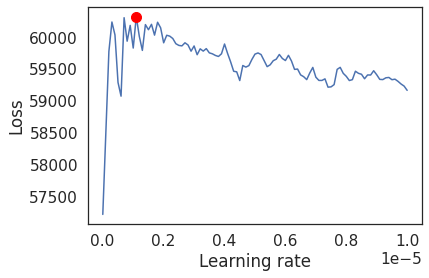

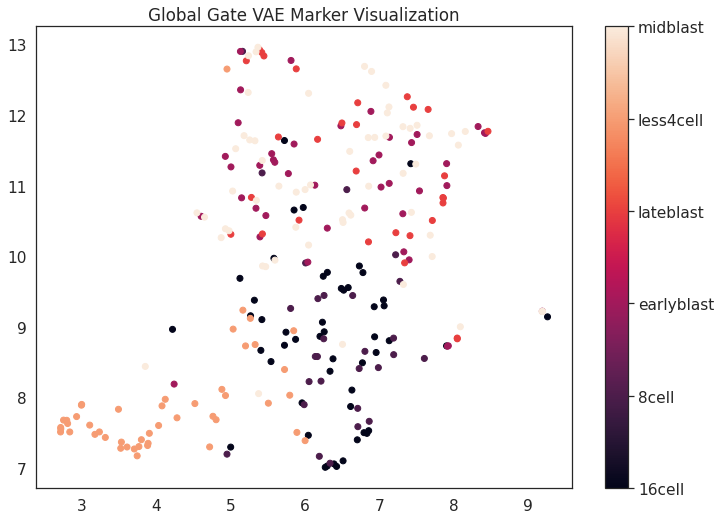

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning:

you defined a validation_step but have no val_dataloader. Skipping val loop

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | encoder    | Sequential | 20.1 M
1 | enc_mean   | Linear     | 65.7 K
2 | enc_logvar | Linear     | 65.7 K
3 | decoder    | Sequential | 19.7 M
4 | dec_logvar | Sequential | 19.7 M
------------------------------------------
59.6 M    Trainable params
0         Non-trainable params
59.6 M    Total params
238.320   Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning:

Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate

Restored states from the checkpoint file at /content/lr_find_temp_model.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | encoder    | Sequential | 20.1 M
1 | enc_mean   | Linear     | 65.7 K
2 | enc_logvar | Linear     | 65.7 K
3 | decoder    | Sequential | 19.7 M
4 | dec_logvar | Sequential | 19.7 M
------------------------------------------
59.6 M    Trainable params
0         Non-trainable params
59.6 M    Total params
238.320   Total estimated m

New Learning Rate 3.5065e-06


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



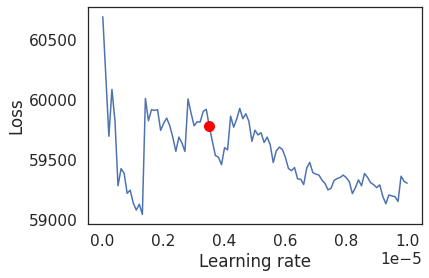

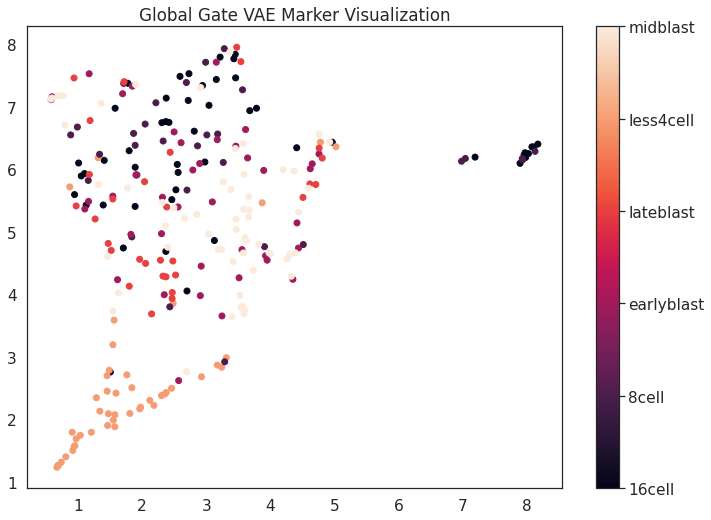

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning:

you defined a validation_step but have no val_dataloader. Skipping val loop

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | encoder    | Sequential | 20.1 M
1 | enc_mean   | Linear     | 65.7 K
2 | enc_logvar | Linear     | 65.7 K
3 | decoder    | Sequential | 19.7 M
4 | dec_logvar | Sequential | 19.7 M
------------------------------------------
59.6 M    Trainable params
0         Non-trainable params
59.6 M    Total params
238.320   Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning:

Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate

Restored states from the checkpoint file at /content/lr_find_temp_model.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | encoder    | Sequential | 20.1 M
1 | enc_mean   | Linear     | 65.7 K
2 | enc_logvar | Linear     | 65.7 K
3 | decoder    | Sequential | 19.7 M
4 | dec_logvar | Sequential | 19.7 M
------------------------------------------
59.6 M    Trainable params
0         Non-trainable params
59.6 M    Total params
238.320   Total estimated m

New Learning Rate 1.3087e-06


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



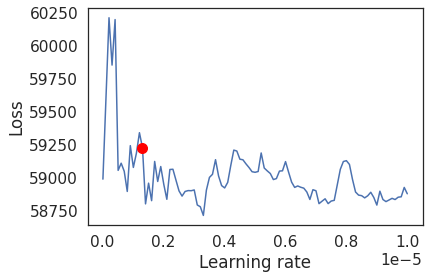

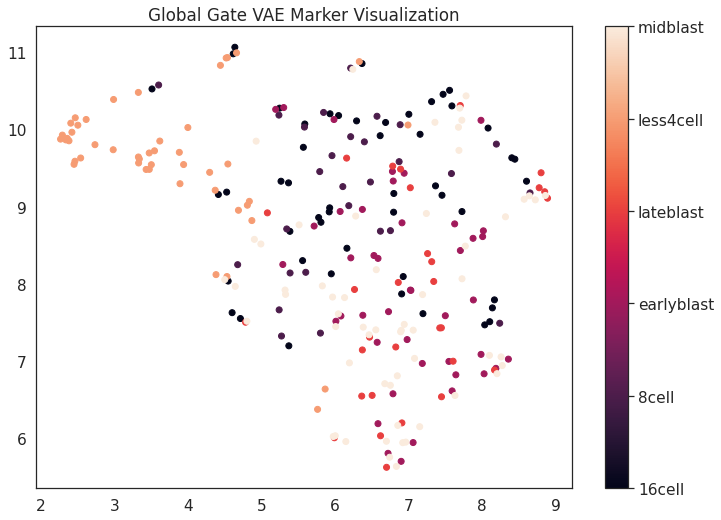

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning:

you defined a validation_step but have no val_dataloader. Skipping val loop

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | encoder    | Sequential | 20.1 M
1 | enc_mean   | Linear     | 65.7 K
2 | enc_logvar | Linear     | 65.7 K
3 | decoder    | Sequential | 19.7 M
4 | dec_logvar | Sequential | 19.7 M
------------------------------------------
59.6 M    Trainable params
0         Non-trainable params
59.6 M    Total params
238.320   Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning:

Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate

Restored states from the checkpoint file at /content/lr_find_temp_model.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | encoder    | Sequential | 20.1 M
1 | enc_mean   | Linear     | 65.7 K
2 | enc_logvar | Linear     | 65.7 K
3 | decoder    | Sequential | 19.7 M
4 | dec_logvar | Sequential | 19.7 M
------------------------------------------
59.6 M    Trainable params
0         Non-trainable params
59.6 M    Total params
238.320   Total estimated m

New Learning Rate 1.1089e-06


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



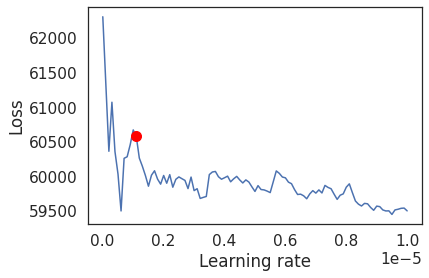

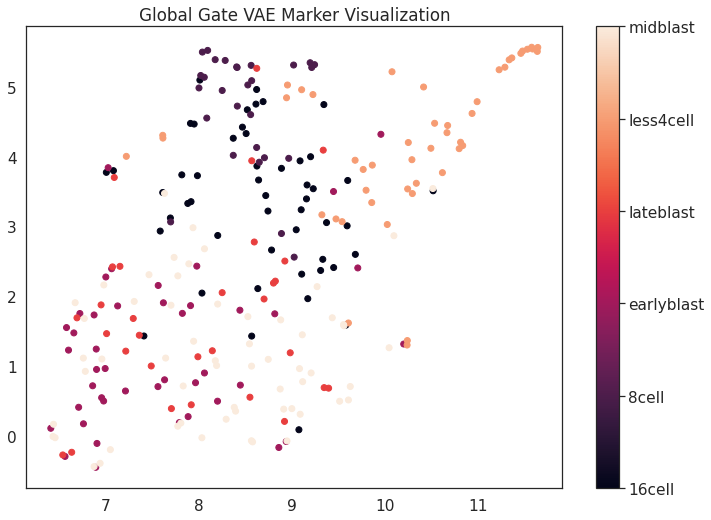

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning:

you defined a validation_step but have no val_dataloader. Skipping val loop

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | encoder    | Sequential | 20.1 M
1 | enc_mean   | Linear     | 65.7 K
2 | enc_logvar | Linear     | 65.7 K
3 | decoder    | Sequential | 19.7 M
4 | dec_logvar | Sequential | 19.7 M
------------------------------------------
59.6 M    Trainable params
0         Non-trainable params
59.6 M    Total params
238.320   Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning:

Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate

Restored states from the checkpoint file at /content/lr_find_temp_model.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | encoder    | Sequential | 20.1 M
1 | enc_mean   | Linear     | 65.7 K
2 | enc_logvar | Linear     | 65.7 K
3 | decoder    | Sequential | 19.7 M
4 | dec_logvar | Sequential | 19.7 M
------------------------------------------
59.6 M    Trainable params
0         Non-trainable params
59.6 M    Total params
238.320   Total estimated m

New Learning Rate 1.7083000000000002e-06


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



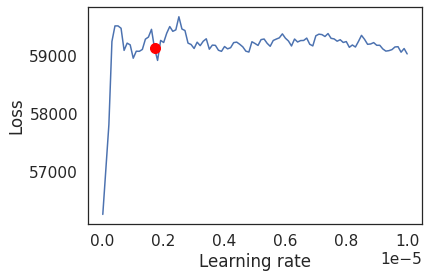

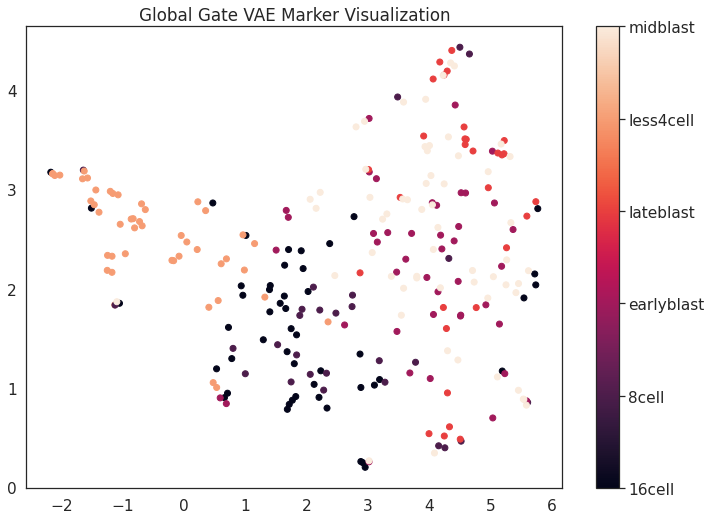

In [ ]:
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.8, 0.0, num_workers=num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    model = VAE_Gumbel_GlobalGate(input_size, hidden_layer_size, z_size, k = k, t = global_t, bias = True, temperature_decay=0.95, batch_norm = batch_norm)
    tmp_path = model_save_path + 'globalgate_vae_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    val_dataloader = None
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus = gpus, tpu_cores = tpu_cores, 
                     min_epochs = min_epochs, max_epochs = max_epochs, auto_lr = True, max_lr = 0.00001, early_stopping_patience =  10, 
                     lr_explore_mode = 'linear', num_lr_rates = 500, precision = 16)
    globalgate_markers = model.markers().clone().cpu().detach().numpy()
    
 
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = globalgate_markers)
    np.save(model_save_path + 'globalgate_vae_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'globalgate_vae_markers_{}.npy'.format(tryy), globalgate_markers)
    np.save(model_save_path + 'experiment_data_folds/globalgate_vae_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Global Gate VAE Marker Visualization', path = viz_save_path + 'globalgate_vae_markers_{}.png'.format(tryy), markers = globalgate_markers)

In [ ]:
model.t

tensor(0.0178)

In [ ]:
results

(0.2692307692307693,
 {'0': {'f1-score': 0.9285714285714286,
   'precision': 0.8666666666666667,
   'recall': 1.0,
   'support': 13},
  '1': {'f1-score': 0.7272727272727273,
   'precision': 1.0,
   'recall': 0.5714285714285714,
   'support': 7},
  '2': {'f1-score': 0.5,
   'precision': 0.5555555555555556,
   'recall': 0.45454545454545453,
   'support': 11},
  '3': {'f1-score': 0.6666666666666666,
   'precision': 0.6666666666666666,
   'recall': 0.6666666666666666,
   'support': 3},
  '4': {'f1-score': 1.0, 'precision': 1.0, 'recall': 1.0, 'support': 10},
  '5': {'f1-score': 0.4210526315789474,
   'precision': 0.36363636363636365,
   'recall': 0.5,
   'support': 8},
  'accuracy': 0.7307692307692307,
  'macro avg': {'f1-score': 0.7072605756816284,
   'precision': 0.742087542087542,
   'recall': 0.6987734487734487,
   'support': 52},
  'weighted avg': {'f1-score': 0.7313607445186393,
   'precision': 0.7555167055167055,
   'recall': 0.7307692307692307,
   'support': 52}},
 array([[13,  0, 

## Train Running State VAE

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning:

you defined a validation_step but have no val_dataloader. Skipping val loop

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type       | Params
----------------------------------------------
0 | encoder        | Sequential | 20.1 M
1 | enc_mean       | Linear     | 65.7 K
2 | enc_logvar     | Linear     | 65.7 K
3 | decoder        | Sequential | 19.7 M
4 | dec_logvar     | Sequential | 19.7 M
5 | weight_creator | Sequential | 39.4 M
----------------------------------------------
99.0 M    Trainable params
0         Non-trainable params
99.0 M    Total params
395.840   Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning:

Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate

Restored states from the checkpoint file at /content/lr_find_temp_model.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type       | Params
----------------------------------------------
0 | encoder        | Sequential | 20.1 M
1 | enc_mean       | Linear     | 65.7 K
2 | enc_logvar     | Linear     | 65.7 K
3 | decoder        | Sequential | 19.7 M
4 | dec_logvar     | Sequential | 19.7 M
5 | weight_creator | Sequential | 39.4 M
----------------------------------------------
99.0 M    Trainable params
0       

New Learning Rate 2.800720000000001e-05


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



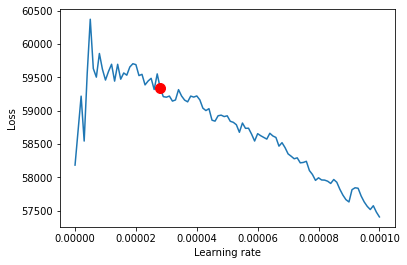

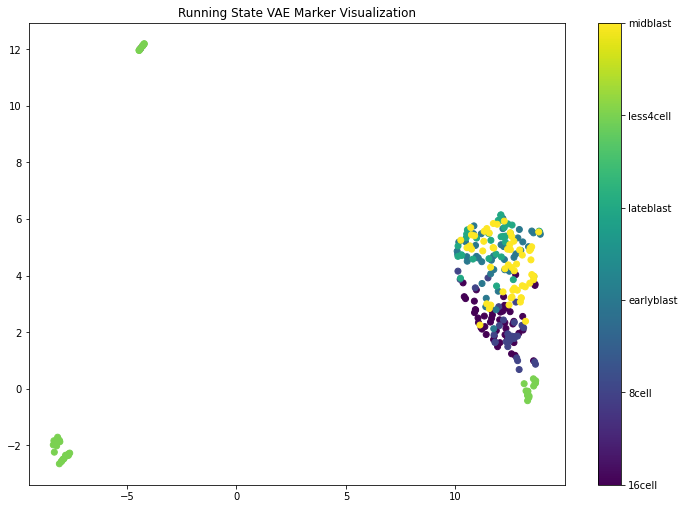

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning:

you defined a validation_step but have no val_dataloader. Skipping val loop

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type       | Params
----------------------------------------------
0 | encoder        | Sequential | 20.1 M
1 | enc_mean       | Linear     | 65.7 K
2 | enc_logvar     | Linear     | 65.7 K
3 | decoder        | Sequential | 19.7 M
4 | dec_logvar     | Sequential | 19.7 M
5 | weight_creator | Sequential | 39.4 M
----------------------------------------------
99.0 M    Trainable params
0         Non-trainable params
99.0 M    Total params
395.840   Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning:

Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate

Restored states from the checkpoint file at /content/lr_find_temp_model.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


New Learning Rate 2.800720000000001e-05



  | Name           | Type       | Params
----------------------------------------------
0 | encoder        | Sequential | 20.1 M
1 | enc_mean       | Linear     | 65.7 K
2 | enc_logvar     | Linear     | 65.7 K
3 | decoder        | Sequential | 19.7 M
4 | dec_logvar     | Sequential | 19.7 M
5 | weight_creator | Sequential | 39.4 M
----------------------------------------------
99.0 M    Trainable params
0         Non-trainable params
99.0 M    Total params
395.840   Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



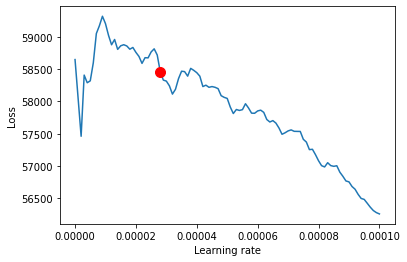

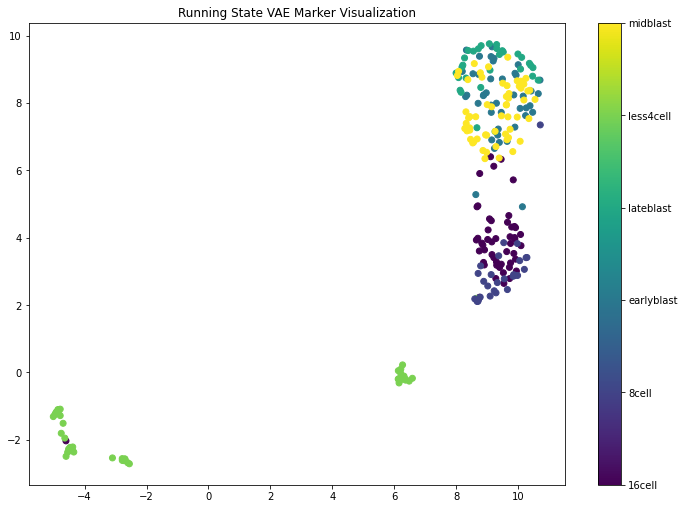

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning:

you defined a validation_step but have no val_dataloader. Skipping val loop

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type       | Params
----------------------------------------------
0 | encoder        | Sequential | 20.1 M
1 | enc_mean       | Linear     | 65.7 K
2 | enc_logvar     | Linear     | 65.7 K
3 | decoder        | Sequential | 19.7 M
4 | dec_logvar     | Sequential | 19.7 M
5 | weight_creator | Sequential | 39.4 M
----------------------------------------------
99.0 M    Trainable params
0         Non-trainable params
99.0 M    Total params
395.840   Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning:

Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate

Restored states from the checkpoint file at /content/lr_find_temp_model.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type       | Params
----------------------------------------------
0 | encoder        | Sequential | 20.1 M
1 | enc_mean       | Linear     | 65.7 K
2 | enc_logvar     | Linear     | 65.7 K
3 | decoder        | Sequential | 19.7 M
4 | dec_logvar     | Sequential | 19.7 M
5 | weight_creator | Sequential | 39.4 M
----------------------------------------------
99.0 M    Trainable params
0       

New Learning Rate 1.7008300000000005e-05


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



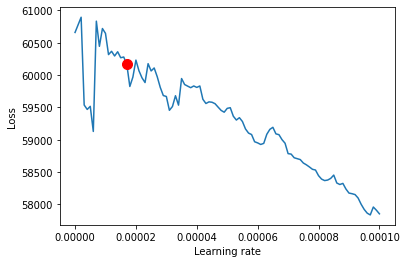

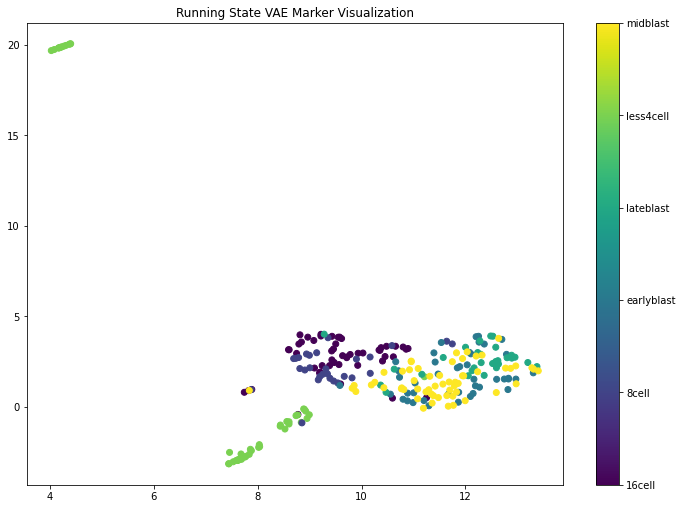

In [ ]:
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.8, 0.0, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    model = VAE_Gumbel_RunningState(input_size, hidden_layer_size, z_size, k = k, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95, batch_norm = batch_norm)
    tmp_path = model_save_path + 'runningstate_vae_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    val_dataloader = None
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=1, min_epochs = min_epochs, max_epochs = max_epochs, auto_lr = True, max_lr = 0.0001, early_stopping_patience = 4, 
                     lr_explore_mode = 'linear', num_lr_rates = 500, precision = 16)
    runningstate_markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = runningstate_markers)
    np.save(model_save_path + 'runningstate_vae_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'runningstate_vae_markers_{}.npy'.format(tryy), runningstate_markers)
    np.save(model_save_path + 'experiment_data_folds/runningstate_vae_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Running State VAE Marker Visualization', path = viz_save_path + 'runningstate_vae_markers_{}.png'.format(tryy), markers = runningstate_markers)

In [ ]:
model.t

tensor(0.0178)

In [ ]:
results

(0.1923076923076923,
 {'0': {'f1-score': 0.9565217391304348,
   'precision': 1.0,
   'recall': 0.9166666666666666,
   'support': 12},
  '1': {'f1-score': 1.0, 'precision': 1.0, 'recall': 1.0, 'support': 5},
  '2': {'f1-score': 0.5,
   'precision': 0.6,
   'recall': 0.42857142857142855,
   'support': 7},
  '3': {'f1-score': 0.6153846153846154,
   'precision': 0.5,
   'recall': 0.8,
   'support': 5},
  '4': {'f1-score': 1.0, 'precision': 1.0, 'recall': 1.0, 'support': 9},
  '5': {'f1-score': 0.7142857142857143,
   'precision': 0.7142857142857143,
   'recall': 0.7142857142857143,
   'support': 14},
  'accuracy': 0.8076923076923077,
  'macro avg': {'f1-score': 0.7976986781334608,
   'precision': 0.8023809523809523,
   'recall': 0.8099206349206348,
   'support': 52},
  'weighted avg': {'f1-score': 0.8087535374324673,
   'precision': 0.8211538461538462,
   'recall': 0.8076923076923077,
   'support': 52}},
 array([[11,  0,  0,  1,  0,  0],
        [ 0,  5,  0,  0,  0,  0],
        [ 0,  0,  3

In [ ]:
model.t

tensor(0.0178)

## Running State Classifier

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning:

you defined a validation_step but have no val_dataloader. Skipping val loop

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type       | Params
----------------------------------------------
0 | encoder        | Sequential | 20.2 M
1 | decoder        | Sequential | 70.2 K
2 | weight_creator | Sequential | 39.4 M
3 | loss_function  | NLLLoss    | 0     
----------------------------------------------
59.6 M    Trainable params
0         Non-trainable params
59.6 M    Total params
238.557   Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning:

Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate

Restored states from the checkpoint file at /content/lr_find_temp_model.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type       | Params
----------------------------------------------
0 | encoder        | Sequential | 20.2 M
1 | decoder        | Sequential | 70.2 K
2 | weight_creator | Sequential | 39.4 M
3 | loss_function  | NLLLoss    | 0     
----------------------------------------------
59.6 M    Trainable params
0         Non-trainable params
59.6 M    Total params
238.557   Total estimated model para

New Learning Rate 0.0001500085


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



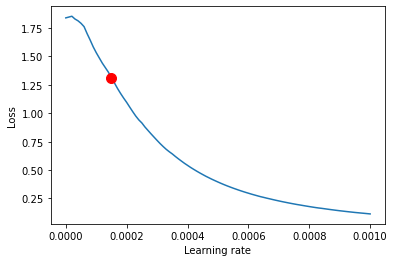

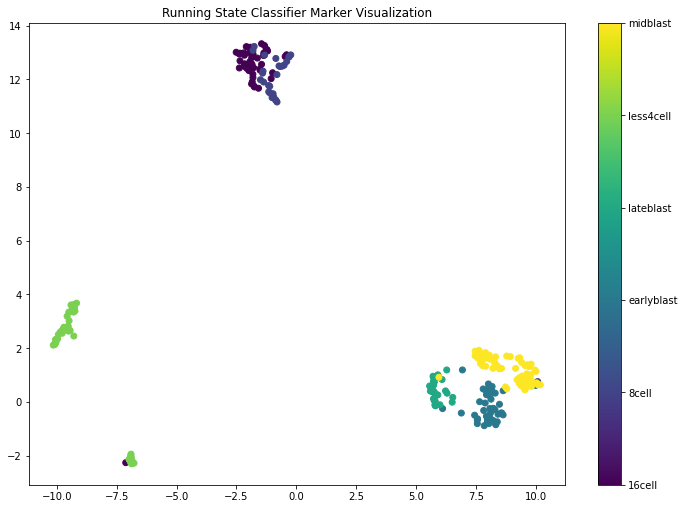

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning:

you defined a validation_step but have no val_dataloader. Skipping val loop

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type       | Params
----------------------------------------------
0 | encoder        | Sequential | 20.2 M
1 | decoder        | Sequential | 70.2 K
2 | weight_creator | Sequential | 39.4 M
3 | loss_function  | NLLLoss    | 0     
----------------------------------------------
59.6 M    Trainable params
0         Non-trainable params
59.6 M    Total params
238.557   Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning:

Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate

Restored states from the checkpoint file at /content/lr_find_temp_model.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type       | Params
----------------------------------------------
0 | encoder        | Sequential | 20.2 M
1 | decoder        | Sequential | 70.2 K
2 | weight_creator | Sequential | 39.4 M
3 | loss_function  | NLLLoss    | 0     
----------------------------------------------
59.6 M    Trainable params
0         Non-trainable params
59.6 M    Total params
238.557   Total estimated model para

New Learning Rate 0.0001500085


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



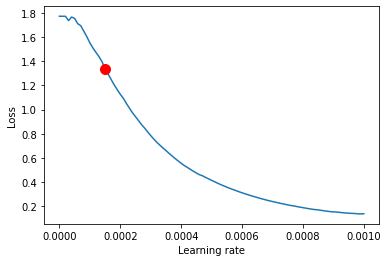

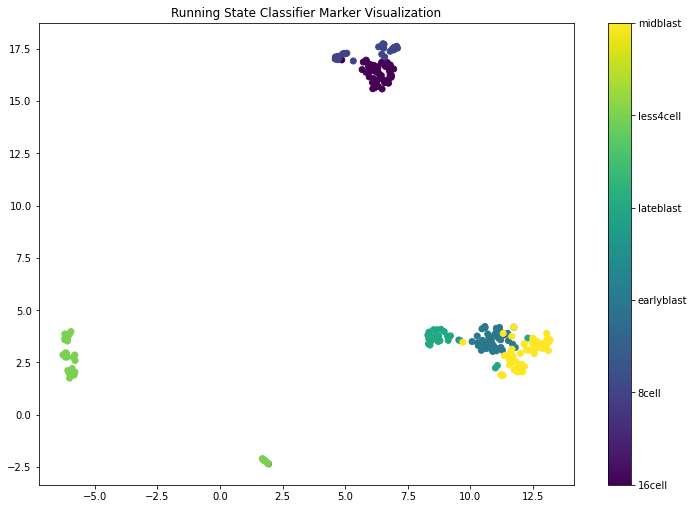

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning:

you defined a validation_step but have no val_dataloader. Skipping val loop

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type       | Params
----------------------------------------------
0 | encoder        | Sequential | 20.2 M
1 | decoder        | Sequential | 70.2 K
2 | weight_creator | Sequential | 39.4 M
3 | loss_function  | NLLLoss    | 0     
----------------------------------------------
59.6 M    Trainable params
0         Non-trainable params
59.6 M    Total params
238.557   Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning:

Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate

Restored states from the checkpoint file at /content/lr_find_temp_model.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type       | Params
----------------------------------------------
0 | encoder        | Sequential | 20.2 M
1 | decoder        | Sequential | 70.2 K
2 | weight_creator | Sequential | 39.4 M
3 | loss_function  | NLLLoss    | 0     
----------------------------------------------
59.6 M    Trainable params
0         Non-trainable params
59.6 M    Total params
238.557   Total estimated model para

New Learning Rate 0.0001500085


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



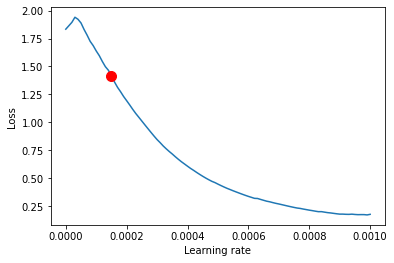

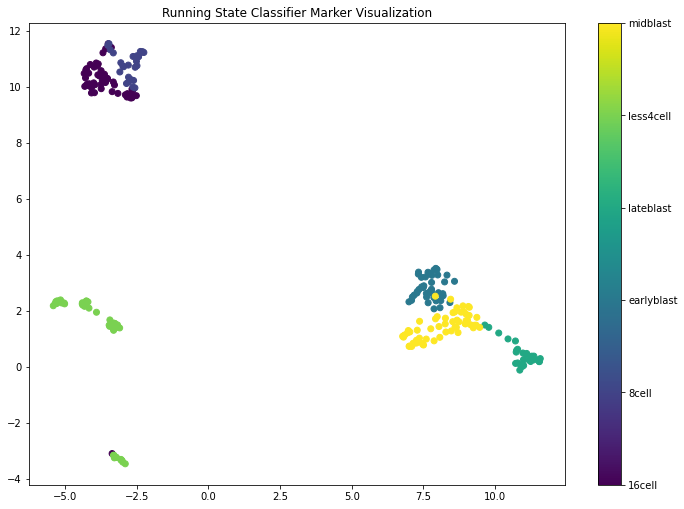

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning:

you defined a validation_step but have no val_dataloader. Skipping val loop

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type       | Params
----------------------------------------------
0 | encoder        | Sequential | 20.2 M
1 | decoder        | Sequential | 70.2 K
2 | weight_creator | Sequential | 39.4 M
3 | loss_function  | NLLLoss    | 0     
----------------------------------------------
59.6 M    Trainable params
0         Non-trainable params
59.6 M    Total params
238.557   Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning:

Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate

Restored states from the checkpoint file at /content/lr_find_temp_model.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type       | Params
----------------------------------------------
0 | encoder        | Sequential | 20.2 M
1 | decoder        | Sequential | 70.2 K
2 | weight_creator | Sequential | 39.4 M
3 | loss_function  | NLLLoss    | 0     
----------------------------------------------
59.6 M    Trainable params
0         Non-trainable params
59.6 M    Total params
238.557   Total estimated model para

New Learning Rate 0.0001500085


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



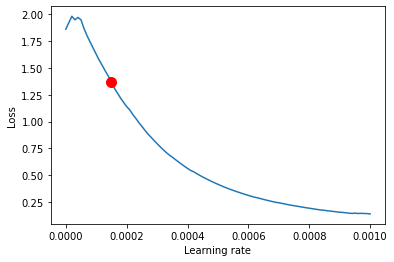

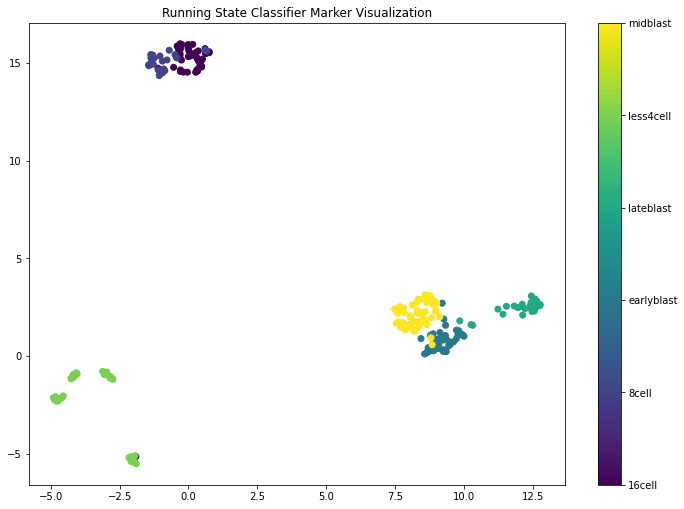

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning:

you defined a validation_step but have no val_dataloader. Skipping val loop

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type       | Params
----------------------------------------------
0 | encoder        | Sequential | 20.2 M
1 | decoder        | Sequential | 70.2 K
2 | weight_creator | Sequential | 39.4 M
3 | loss_function  | NLLLoss    | 0     
----------------------------------------------
59.6 M    Trainable params
0         Non-trainable params
59.6 M    Total params
238.557   Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning:

Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate

Restored states from the checkpoint file at /content/lr_find_temp_model.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type       | Params
----------------------------------------------
0 | encoder        | Sequential | 20.2 M
1 | decoder        | Sequential | 70.2 K
2 | weight_creator | Sequential | 39.4 M
3 | loss_function  | NLLLoss    | 0     
----------------------------------------------
59.6 M    Trainable params
0         Non-trainable params
59.6 M    Total params
238.557   Total estimated model para

New Learning Rate 0.0001600084


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



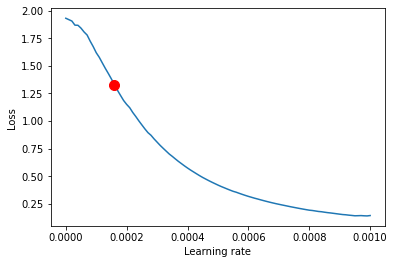

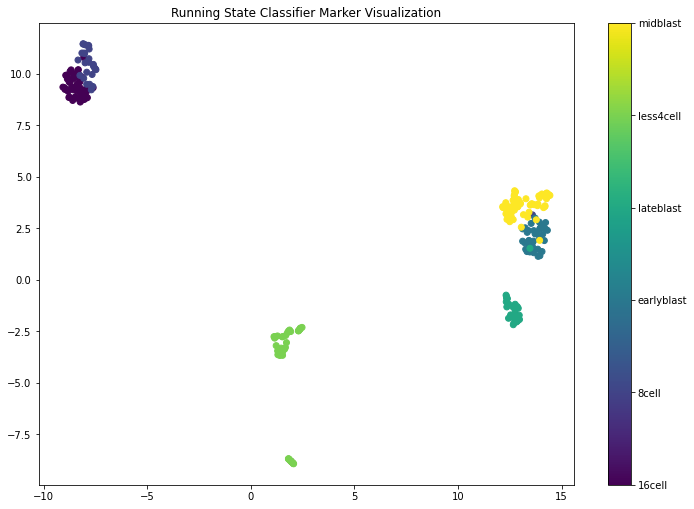

In [ ]:
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.8, 0.0, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    
    model = GumbelClassifier(input_size, hidden_layer_size, z_size, num_classes = len(encoder.classes_), 
                             k = k, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95, batch_norm = batch_norm)
    tmp_path = model_save_path + 'runningstate_classifier_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    val_dataloader = None
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, 
                     min_epochs = min_epochs, max_epochs = max_epochs, auto_lr = True, early_stopping_patience = 3, precision = 16, lr_explore_mode = 'linear', num_lr_rates=500)
    runningstate_markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = runningstate_markers)
    np.save(model_save_path + 'runningstate_classifier_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'runningstate_classifier_markers_{}.npy'.format(tryy), runningstate_markers)
    np.save(model_save_path + 'experiment_data_folds/runningstate_classifier_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Running State Classifier Marker Visualization', path = viz_save_path + 'runningstate_classifier_markers_{}.png'.format(tryy), markers = runningstate_markers)

In [ ]:
model.lr

0.0001600084

In [ ]:
model.t

tensor(0.0178)

In [ ]:
model.hparams.lr

0.0001600084

In [ ]:
results

(0.05769230769230771,
 {'0': {'f1-score': 0.9230769230769231,
   'precision': 0.9230769230769231,
   'recall': 0.9230769230769231,
   'support': 13},
  '1': {'f1-score': 0.888888888888889,
   'precision': 1.0,
   'recall': 0.8,
   'support': 5},
  '2': {'f1-score': 0.8571428571428571,
   'precision': 1.0,
   'recall': 0.75,
   'support': 4},
  '3': {'f1-score': 1.0, 'precision': 1.0, 'recall': 1.0, 'support': 6},
  '4': {'f1-score': 0.9523809523809523,
   'precision': 0.9090909090909091,
   'recall': 1.0,
   'support': 10},
  '5': {'f1-score': 0.9655172413793104,
   'precision': 0.9333333333333333,
   'recall': 1.0,
   'support': 14},
  'accuracy': 0.9423076923076923,
  'macro avg': {'f1-score': 0.9311678104781554,
   'precision': 0.960916860916861,
   'recall': 0.9121794871794872,
   'support': 52},
  'weighted avg': {'f1-score': 0.9406551303103027,
   'precision': 0.9453379953379953,
   'recall': 0.9423076923076923,
   'support': 52}},
 array([[12,  0,  0,  0,  1,  0],
        [ 1,  

## RunningState VAE+Classifier

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params
------------------------------------------------------
0 | encoder                | Sequential | 20.1 M
1 | enc_mean               | Linear     | 65.7 K
2 | enc_logvar             | Linear     | 65.7 K
3 | decoder                | Sequential | 19.7 M
4 | dec_logvar             | Sequential | 19.7 M
5 | weight_creator         | Sequential | 39.4 M
6 | classification_decoder | Sequential | 70.2 K
7 | classification_loss    | NLLLoss    | 0     
------------------------------------------------------
99.0 M    Trainable params
0         Non-trainable params
99.0 M    Total params
396.121   Total estimated model params size (MB)


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning:

Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate



--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------
-------------------------

Restored states from the checkpoint file at /content/lr_find_temp_model.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params
------------------------------------------------------
0 | encoder                | Sequential | 20.1 M
1 | enc_mean               | Linear     | 65.7 K
2 | enc_logvar             | Linear     | 65.7 K
3 | decoder                | Sequential | 19.7 M
4 | dec_logvar             | Sequential | 19.7 M
5 | weight_creator         | Sequential | 39.4 M
6 | classification_decoder | Sequential | 70.2 K
7 | classification_loss    | NLLLoss    | 0     
------------------------------------------------------
99.0 M    Trainable params
0         Non-trainable params
99.0 M    Total params
396.121   Total estimated model params size (MB)


New Learning Rate 0.0007100029


Validation sanity check: 0it [00:00, ?it/s]

Training: 3it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



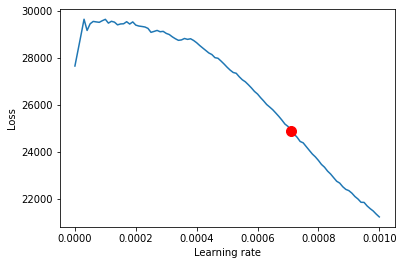

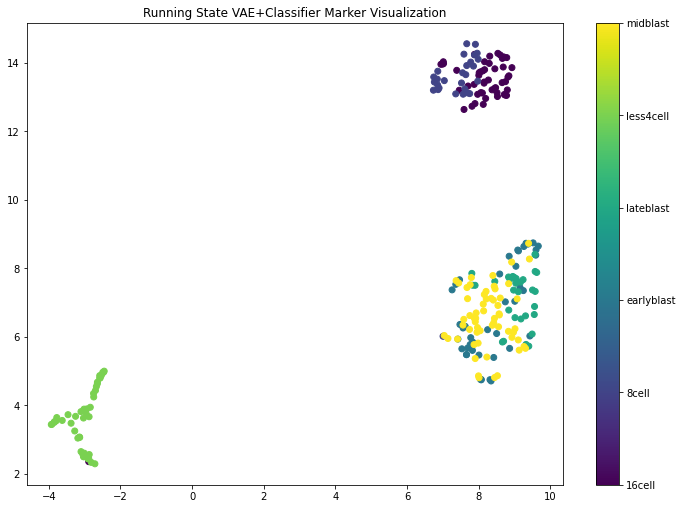

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params
------------------------------------------------------
0 | encoder                | Sequential | 20.1 M
1 | enc_mean               | Linear     | 65.7 K
2 | enc_logvar             | Linear     | 65.7 K
3 | decoder                | Sequential | 19.7 M
4 | dec_logvar             | Sequential | 19.7 M
5 | weight_creator         | Sequential | 39.4 M
6 | classification_decoder | Sequential | 70.2 K
7 | classification_loss    | NLLLoss    | 0     
------------------------------------------------------
99.0 M    Trainable params
0         Non-trainable params
99.0 M    Total params
396.121   Total estimated model params size (MB)


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning:

Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate



--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------
-------------------------

Restored states from the checkpoint file at /content/lr_find_temp_model.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params
------------------------------------------------------
0 | encoder                | Sequential | 20.1 M
1 | enc_mean               | Linear     | 65.7 K
2 | enc_logvar             | Linear     | 65.7 K
3 | decoder                | Sequential | 19.7 M
4 | dec_logvar             | Sequential | 19.7 M
5 | weight_creator         | Sequential | 39.4 M
6 | classification_decoder | Sequential | 70.2 K
7 | classification_loss    | NLLLoss    | 0     
------------------------------------------------------
99.0 M    Trainable params
0         Non-trainable params
99.0 M    Total params
396.121   Total estimated model params size (MB)


New Learning Rate 0.0006800032000000002


Validation sanity check: 0it [00:00, ?it/s]

Training: 3it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



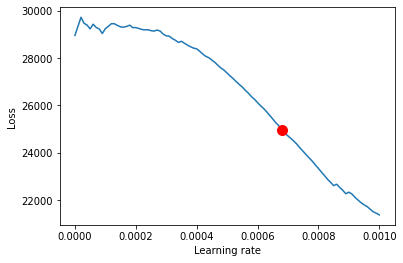

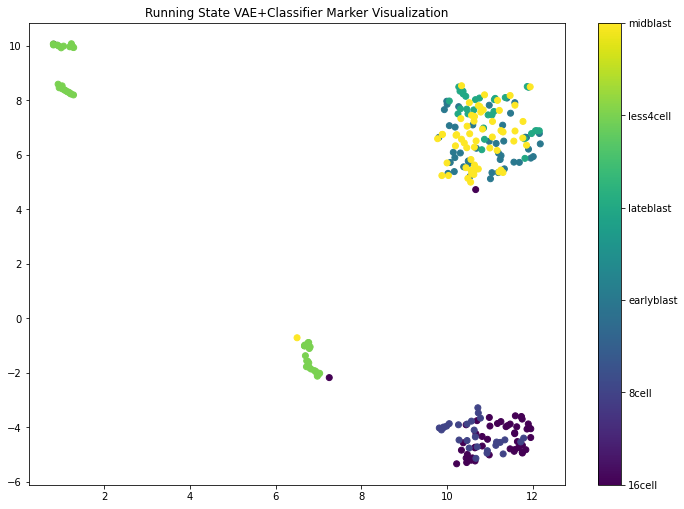

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params
------------------------------------------------------
0 | encoder                | Sequential | 20.1 M
1 | enc_mean               | Linear     | 65.7 K
2 | enc_logvar             | Linear     | 65.7 K
3 | decoder                | Sequential | 19.7 M
4 | dec_logvar             | Sequential | 19.7 M
5 | weight_creator         | Sequential | 39.4 M
6 | classification_decoder | Sequential | 70.2 K
7 | classification_loss    | NLLLoss    | 0     
------------------------------------------------------
99.0 M    Trainable params
0         Non-trainable params
99.0 M    Total params
396.121   Total estimated model params size (MB)


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning:

Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate



--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------
-------------------------

Restored states from the checkpoint file at /content/lr_find_temp_model.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params
------------------------------------------------------
0 | encoder                | Sequential | 20.1 M
1 | enc_mean               | Linear     | 65.7 K
2 | enc_logvar             | Linear     | 65.7 K
3 | decoder                | Sequential | 19.7 M
4 | dec_logvar             | Sequential | 19.7 M
5 | weight_creator         | Sequential | 39.4 M
6 | classification_decoder | Sequential | 70.2 K
7 | classification_loss    | NLLLoss    | 0     
------------------------------------------------------
99.0 M    Trainable params
0         Non-trainable params
99.0 M    Total params
396.121   Total estimated model params size (MB)


New Learning Rate 0.0007900021000000002


Validation sanity check: 0it [00:00, ?it/s]

Training: 3it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



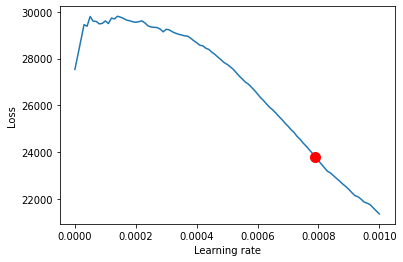

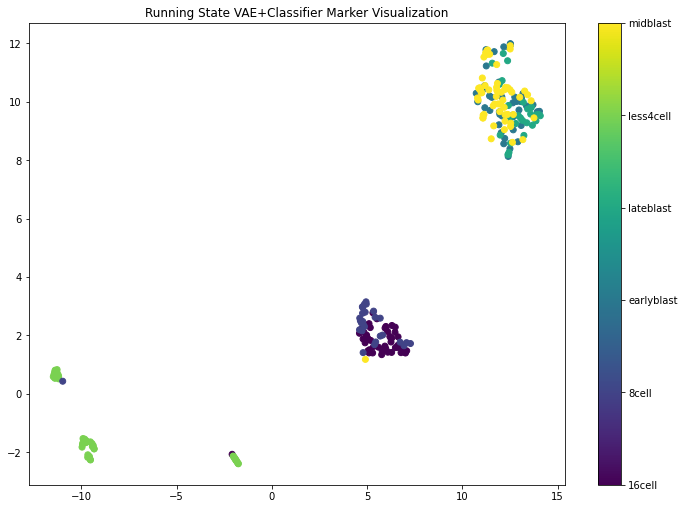

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params
------------------------------------------------------
0 | encoder                | Sequential | 20.1 M
1 | enc_mean               | Linear     | 65.7 K
2 | enc_logvar             | Linear     | 65.7 K
3 | decoder                | Sequential | 19.7 M
4 | dec_logvar             | Sequential | 19.7 M
5 | weight_creator         | Sequential | 39.4 M
6 | classification_decoder | Sequential | 70.2 K
7 | classification_loss    | NLLLoss    | 0     
------------------------------------------------------
99.0 M    Trainable params
0         Non-trainable params
99.0 M    Total params
396.121   Total estimated model params size (MB)


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning:

Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate



--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------
-------------------------

Restored states from the checkpoint file at /content/lr_find_temp_model.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params
------------------------------------------------------
0 | encoder                | Sequential | 20.1 M
1 | enc_mean               | Linear     | 65.7 K
2 | enc_logvar             | Linear     | 65.7 K
3 | decoder                | Sequential | 19.7 M
4 | dec_logvar             | Sequential | 19.7 M
5 | weight_creator         | Sequential | 39.4 M
6 | classification_decoder | Sequential | 70.2 K
7 | classification_loss    | NLLLoss    | 0     
------------------------------------------------------
99.0 M    Trainable params
0         Non-trainable params
99.0 M    Total params
396.121   Total estimated model params size (MB)


New Learning Rate 0.0009600004


Validation sanity check: 0it [00:00, ?it/s]

Training: 3it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



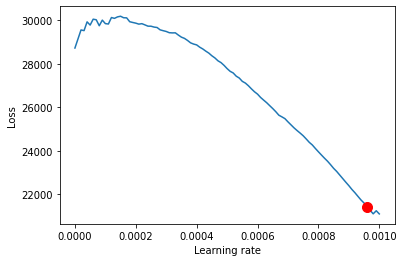

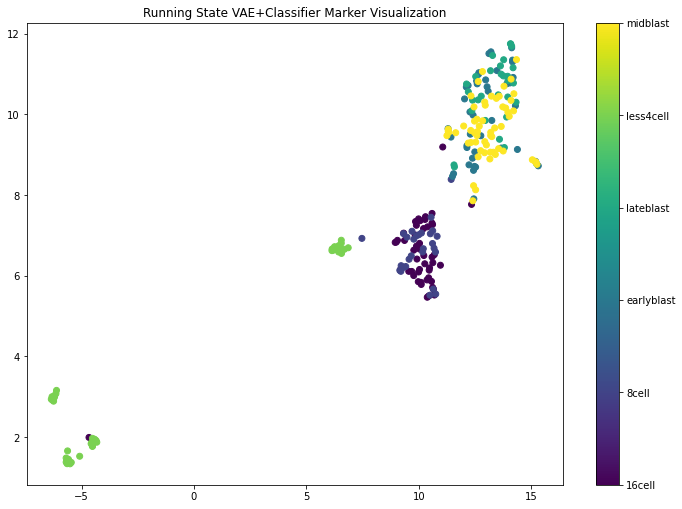

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params
------------------------------------------------------
0 | encoder                | Sequential | 20.1 M
1 | enc_mean               | Linear     | 65.7 K
2 | enc_logvar             | Linear     | 65.7 K
3 | decoder                | Sequential | 19.7 M
4 | dec_logvar             | Sequential | 19.7 M
5 | weight_creator         | Sequential | 39.4 M
6 | classification_decoder | Sequential | 70.2 K
7 | classification_loss    | NLLLoss    | 0     
------------------------------------------------------
99.0 M    Trainable params
0         Non-trainable params
99.0 M    Total params
396.121   Total estimated model params size (MB)


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning:

Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate



--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------
-------------------------

Restored states from the checkpoint file at /content/lr_find_temp_model.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params
------------------------------------------------------
0 | encoder                | Sequential | 20.1 M
1 | enc_mean               | Linear     | 65.7 K
2 | enc_logvar             | Linear     | 65.7 K
3 | decoder                | Sequential | 19.7 M
4 | dec_logvar             | Sequential | 19.7 M
5 | weight_creator         | Sequential | 39.4 M
6 | classification_decoder | Sequential | 70.2 K
7 | classification_loss    | NLLLoss    | 0     
------------------------------------------------------
99.0 M    Trainable params
0         Non-trainable params
99.0 M    Total params
396.121   Total estimated model params size (MB)


New Learning Rate 0.0008100019000000002


Validation sanity check: 0it [00:00, ?it/s]

Training: 3it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



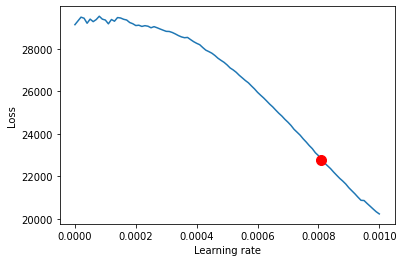

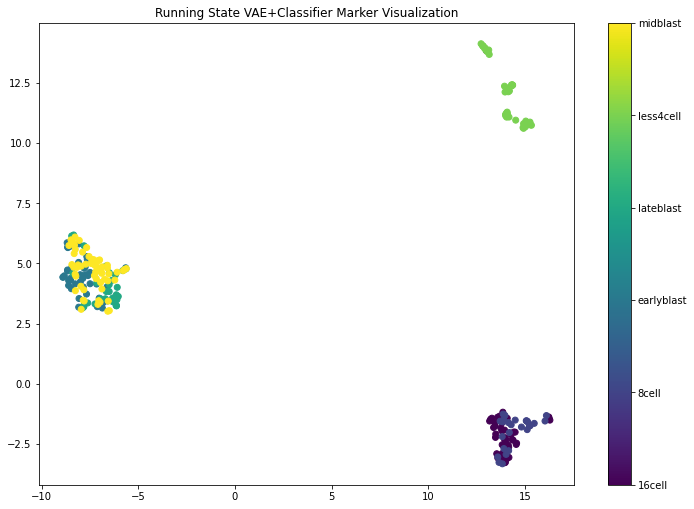

In [ ]:
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    
    model = RunningState_VAE_Classifier(input_size, hidden_layer_size, z_size, num_classes = len(encoder.classes_), 
                             k = k, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95, batch_norm = batch_norm)
    tmp_path = model_save_path + 'runningstate_vae+classifier_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, 
                     min_epochs = 25, max_epochs = 100, auto_lr = True, early_stopping_patience = 3, precision = 16, lr_explore_mode = 'linear', num_lr_rates=500)
    markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = markers)
    np.save(model_save_path + 'runningstate_vae+classifier_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'runningstate_vae+classifier_markers_{}.npy'.format(tryy), markers)
    np.save(model_save_path + 'experiment_data_folds/runningstate_vae+classifier_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Running State VAE+Classifier Marker Visualization', path = viz_save_path + 'runningstate_vae+classifier_markers_{}.png'.format(tryy), markers = markers)

In [ ]:
results

(0.1923076923076923,
 {'0': {'f1-score': 0.8571428571428572,
   'precision': 0.8181818181818182,
   'recall': 0.9,
   'support': 10},
  '1': {'f1-score': 0.3333333333333333,
   'precision': 0.5,
   'recall': 0.25,
   'support': 4},
  '2': {'f1-score': 0.6666666666666666,
   'precision': 0.8,
   'recall': 0.5714285714285714,
   'support': 7},
  '3': {'f1-score': 0.8333333333333334,
   'precision': 0.8333333333333334,
   'recall': 0.8333333333333334,
   'support': 6},
  '4': {'f1-score': 0.9473684210526316,
   'precision': 0.9,
   'recall': 1.0,
   'support': 9},
  '5': {'f1-score': 0.823529411764706,
   'precision': 0.7777777777777778,
   'recall': 0.875,
   'support': 16},
  'accuracy': 0.8076923076923077,
  'macro avg': {'f1-score': 0.7435623372155881,
   'precision': 0.7715488215488215,
   'recall': 0.7382936507936507,
   'support': 52},
  'weighted avg': {'f1-score': 0.7937349028680298,
   'precision': 0.7947358197358197,
   'recall': 0.8076923076923077,
   'support': 52}},
 array([

## Concrete VAE

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning:

you defined a validation_step but have no val_dataloader. Skipping val loop

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | encoder    | Sequential | 553 K 
1 | enc_mean   | Linear     | 65.7 K
2 | enc_logvar | Linear     | 65.7 K
3 | decoder    | Sequential | 19.7 M
4 | dec_logvar | Sequential | 19.7 M
------------------------------------------
41.9 M    Trainable params
0         Non-trainable params
41.9 M    Total params
167.680   Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning:

Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate

Restored states from the checkpoint file at /content/lr_find_temp_model.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | encoder    | Sequential | 553 K 
1 | enc_mean   | Linear     | 65.7 K
2 | enc_logvar | Linear     | 65.7 K
3 | decoder    | Sequential | 19.7 M
4 | dec_logvar | Sequential | 19.7 M
------------------------------------------
41.9 M    Trainable params
0         Non-trainable params
41.9 M    Total params
167.680   Total estimated m

New Learning Rate 2.2007800000000003e-05


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



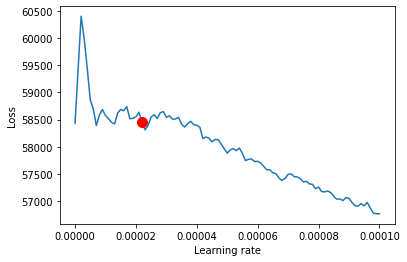

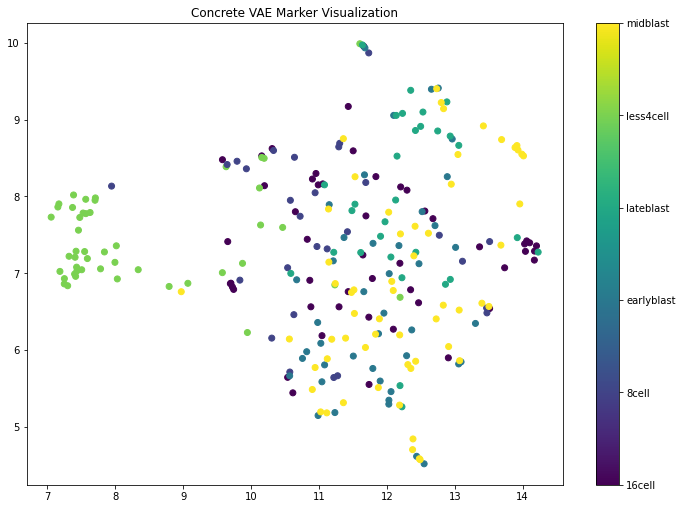

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning:

you defined a validation_step but have no val_dataloader. Skipping val loop

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | encoder    | Sequential | 553 K 
1 | enc_mean   | Linear     | 65.7 K
2 | enc_logvar | Linear     | 65.7 K
3 | decoder    | Sequential | 19.7 M
4 | dec_logvar | Sequential | 19.7 M
------------------------------------------
41.9 M    Trainable params
0         Non-trainable params
41.9 M    Total params
167.680   Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning:

Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate

Restored states from the checkpoint file at /content/lr_find_temp_model.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | encoder    | Sequential | 553 K 
1 | enc_mean   | Linear     | 65.7 K
2 | enc_logvar | Linear     | 65.7 K
3 | decoder    | Sequential | 19.7 M
4 | dec_logvar | Sequential | 19.7 M
------------------------------------------
41.9 M    Trainable params
0         Non-trainable params
41.9 M    Total params
167.680   Total estimated m

New Learning Rate 2.2007800000000003e-05


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



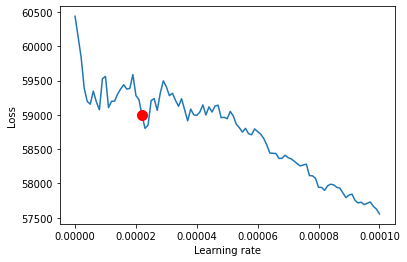

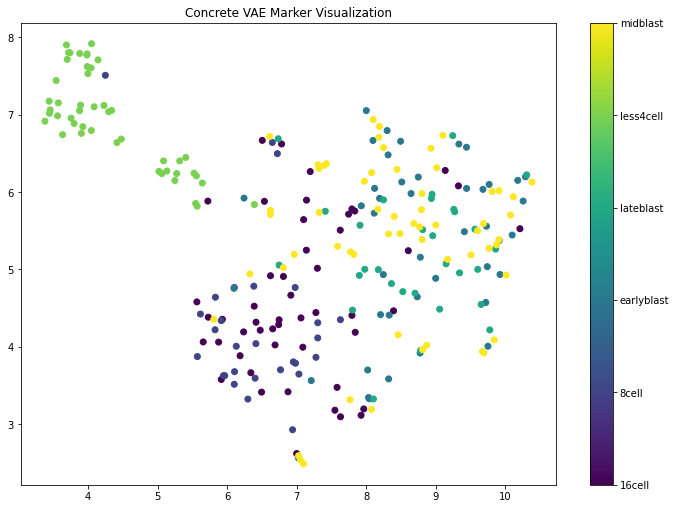

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning:

you defined a validation_step but have no val_dataloader. Skipping val loop

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | encoder    | Sequential | 553 K 
1 | enc_mean   | Linear     | 65.7 K
2 | enc_logvar | Linear     | 65.7 K
3 | decoder    | Sequential | 19.7 M
4 | dec_logvar | Sequential | 19.7 M
------------------------------------------
41.9 M    Trainable params
0         Non-trainable params
41.9 M    Total params
167.680   Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning:

Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate

Restored states from the checkpoint file at /content/lr_find_temp_model.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | encoder    | Sequential | 553 K 
1 | enc_mean   | Linear     | 65.7 K
2 | enc_logvar | Linear     | 65.7 K
3 | decoder    | Sequential | 19.7 M
4 | dec_logvar | Sequential | 19.7 M
------------------------------------------
41.9 M    Trainable params
0         Non-trainable params
41.9 M    Total params
167.680   Total estimated m

New Learning Rate 1.9008100000000005e-05


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



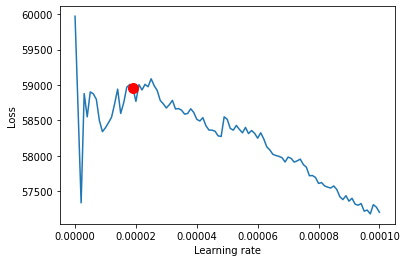

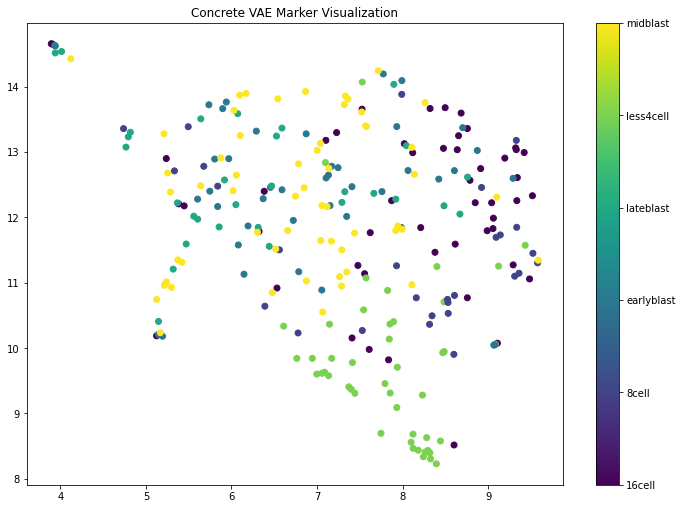

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning:

you defined a validation_step but have no val_dataloader. Skipping val loop

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | encoder    | Sequential | 553 K 
1 | enc_mean   | Linear     | 65.7 K
2 | enc_logvar | Linear     | 65.7 K
3 | decoder    | Sequential | 19.7 M
4 | dec_logvar | Sequential | 19.7 M
------------------------------------------
41.9 M    Trainable params
0         Non-trainable params
41.9 M    Total params
167.680   Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning:

Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate

Restored states from the checkpoint file at /content/lr_find_temp_model.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | encoder    | Sequential | 553 K 
1 | enc_mean   | Linear     | 65.7 K
2 | enc_logvar | Linear     | 65.7 K
3 | decoder    | Sequential | 19.7 M
4 | dec_logvar | Sequential | 19.7 M
------------------------------------------
41.9 M    Trainable params
0         Non-trainable params
41.9 M    Total params
167.680   Total estimated m

New Learning Rate 1.3008700000000001e-05


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



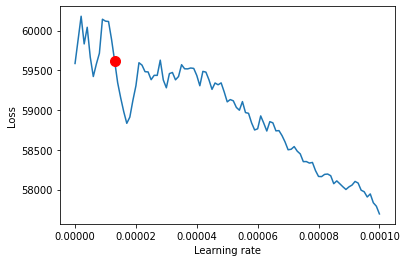

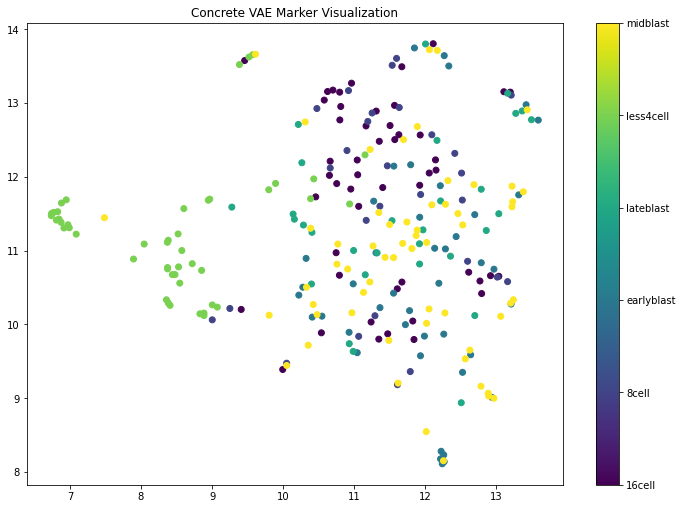

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning:

you defined a validation_step but have no val_dataloader. Skipping val loop

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | encoder    | Sequential | 553 K 
1 | enc_mean   | Linear     | 65.7 K
2 | enc_logvar | Linear     | 65.7 K
3 | decoder    | Sequential | 19.7 M
4 | dec_logvar | Sequential | 19.7 M
------------------------------------------
41.9 M    Trainable params
0         Non-trainable params
41.9 M    Total params
167.680   Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning:

Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate

Restored states from the checkpoint file at /content/lr_find_temp_model.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | encoder    | Sequential | 553 K 
1 | enc_mean   | Linear     | 65.7 K
2 | enc_logvar | Linear     | 65.7 K
3 | decoder    | Sequential | 19.7 M
4 | dec_logvar | Sequential | 19.7 M
------------------------------------------
41.9 M    Trainable params
0         Non-trainable params
41.9 M    Total params
167.680   Total estimated m

New Learning Rate 1.6008400000000004e-05


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



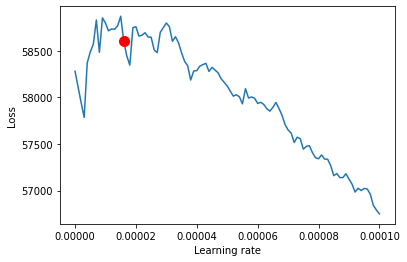

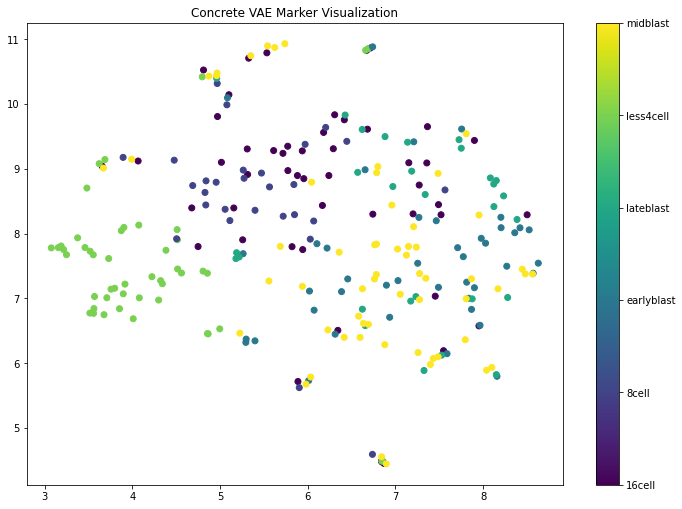

In [ ]:
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.8, 0.0, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    model = ConcreteVAE_NMSL(input_size, hidden_layer_size, z_size, k = k, t = global_t, bias = True, temperature_decay = 0.9, batch_norm = batch_norm)
    tmp_path = model_save_path + 'concrete_vae_{}.ckpt'.format(tryy)
    val_dataloader = None
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=1, min_epochs = min_epochs, max_epochs = max_epochs, auto_lr = True, max_lr = 0.0001, early_stopping_patience = 3, 
                     lr_explore_mode = 'linear', num_lr_rates = 500, precision = 16)
    concrete_vae_markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = concrete_vae_markers)
    np.save(model_save_path + 'concrete_vae_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'concrete_vae_markers_{}.npy'.format(tryy), concrete_vae_markers)
    np.save(model_save_path + 'experiment_data_folds/concrete_vae_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Concrete VAE Marker Visualization', path = viz_save_path + 'concrete_vae_markers_{}.png'.format(tryy), markers = concrete_vae_markers)

In [ ]:
results = np.load(model_save_path + 'concrete_vae_results_{}.npy'.format(1), allow_pickle = True)

In [ ]:
results

array([0.5,
       {'0': {'precision': 0.42857142857142855, 'recall': 0.5454545454545454, 'f1-score': 0.4799999999999999, 'support': 11}, '1': {'precision': 0.5, 'recall': 0.16666666666666666, 'f1-score': 0.25, 'support': 6}, '2': {'precision': 0.16666666666666666, 'recall': 0.08333333333333333, 'f1-score': 0.1111111111111111, 'support': 12}, '3': {'precision': 0.5, 'recall': 0.5, 'f1-score': 0.5, 'support': 4}, '4': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 8}, '5': {'precision': 0.4444444444444444, 'recall': 0.7272727272727273, 'f1-score': 0.5517241379310345, 'support': 11}, 'accuracy': 0.5, 'macro avg': {'precision': 0.5066137566137566, 'recall': 0.5037878787878788, 'f1-score': 0.482139208173691, 'support': 52}, 'weighted avg': {'precision': 0.4731379731379732, 'recall': 0.5, 'f1-score': 0.46504420866489826, 'support': 52}},
       array([[6, 1, 3, 1, 0, 0],
       [2, 1, 1, 0, 0, 2],
       [3, 0, 1, 1, 0, 7],
       [1, 0, 0, 2, 0, 1],
       [0, 0, 0, 0, 8, 0]

## LassoNet

In [25]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



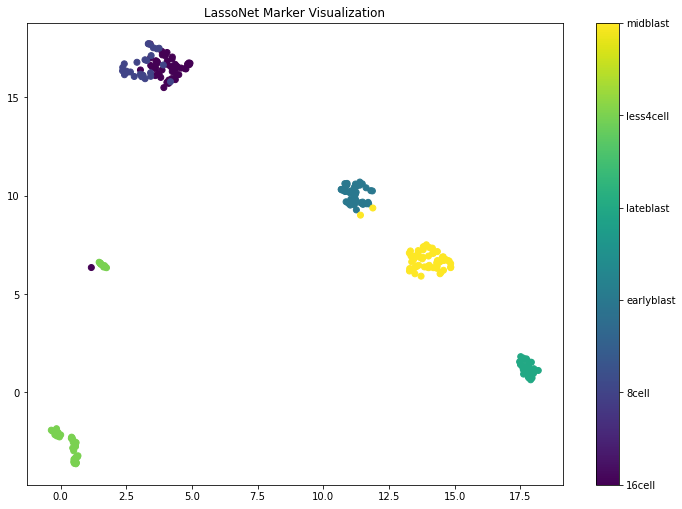

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



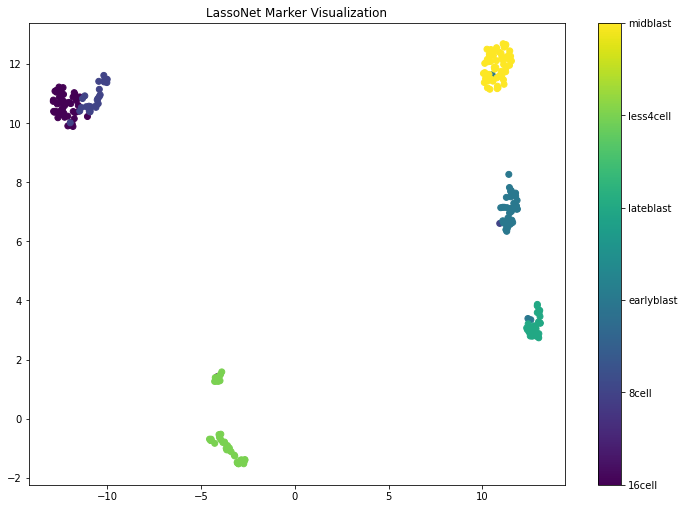

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



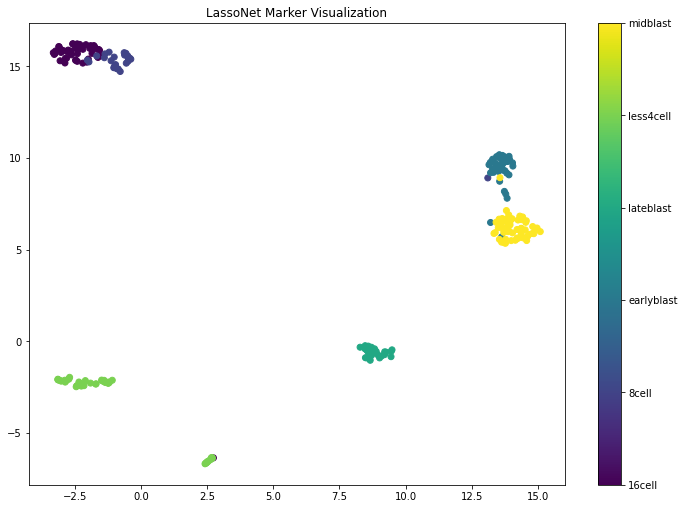

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



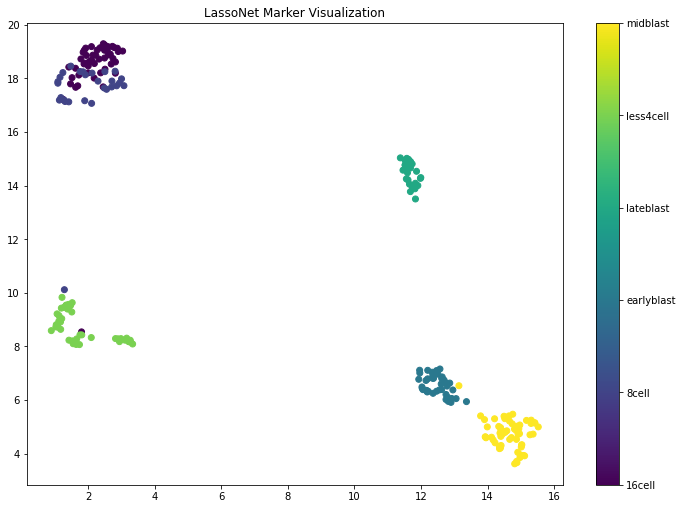

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



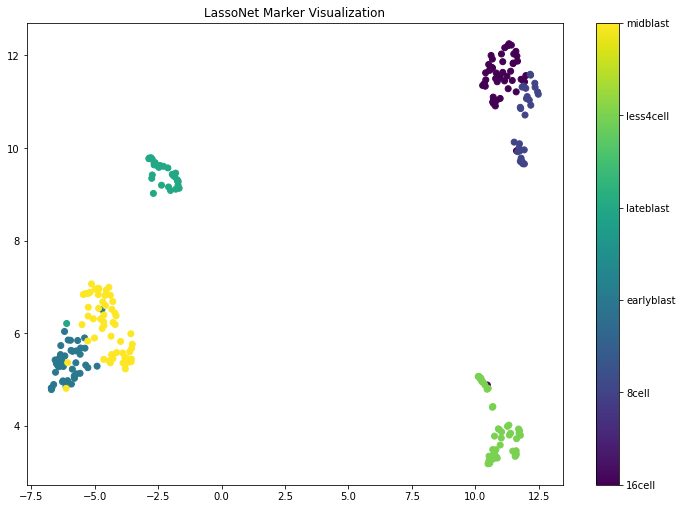

In [29]:
for tryy in range(1,num_times+1):  
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[train_indices, :]
    y_train = y[train_indices]
    X_val = X[val_indices,:]
    y_val = y[val_indices]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    # concretevae, vaes, and gumbelclassifier all use z_size, so this should too actually
    model = LassoNetClassifier(batch_size = X.shape[0]//10)
    model.path(X_train, y_train, X_val = X_val, y_val = y_val)
    lasso_net_markers = torch.argsort(model.feature_importances_, descending = True).cpu().numpy()[:k]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = lasso_net_markers)
    np.save(model_save_path + 'lasso_net_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'lasso_net_markers_{}.npy'.format(tryy), lasso_net_markers)
    np.save(model_save_path + 'experiment_data_folds/lasso_net_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'LassoNet Marker Visualization', path = viz_save_path + 'lasso_net_markers_{}.png'.format(tryy), markers = lasso_net_markers)

In [30]:
results

(0.11538461538461542,
 {'0': {'f1-score': 1.0, 'precision': 1.0, 'recall': 1.0, 'support': 10},
  '1': {'f1-score': 1.0, 'precision': 1.0, 'recall': 1.0, 'support': 2},
  '2': {'f1-score': 0.7857142857142856,
   'precision': 0.8461538461538461,
   'recall': 0.7333333333333333,
   'support': 15},
  '3': {'f1-score': 1.0, 'precision': 1.0, 'recall': 1.0, 'support': 3},
  '4': {'f1-score': 1.0, 'precision': 1.0, 'recall': 1.0, 'support': 9},
  '5': {'f1-score': 0.7857142857142856,
   'precision': 0.7333333333333333,
   'recall': 0.8461538461538461,
   'support': 13},
  'accuracy': 0.8846153846153846,
  'macro avg': {'f1-score': 0.9285714285714285,
   'precision': 0.92991452991453,
   'recall': 0.9299145299145298,
   'support': 52},
  'weighted avg': {'f1-score': 0.8846153846153846,
   'precision': 0.8889546351084813,
   'recall': 0.8846153846153846,
   'support': 52}},
 array([[10,  0,  0,  0,  0,  0],
        [ 0,  2,  0,  0,  0,  0],
        [ 0,  0, 11,  0,  0,  4],
        [ 0,  0,  0

## Get Model Metrics from KNNs Classifiers

In [31]:
from sklearn.neighbors import KNeighborsClassifier

In [32]:
def generate_metrics_from_saved_files(X, y, folds_path, markers_path, classifier_model, save_path):
    train_indices, val_indices, test_indices = np.load(folds_path, allow_pickle = True)
    markers = np.load(markers_path, allow_pickle = True)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices, :]
    y_test = y[test_indices]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = markers, model = classifier_model)

    np.save(save_path, results)
    return

def batch_generate_metrics_from_saved_files(X, y, format_folds_path, format_markers_path, format_save_path):
    for tryy in range(1, num_times+1):
        classifier_model = KNeighborsClassifier()
        generate_metrics_from_saved_files(X, y, format_folds_path.format(tryy), format_markers_path.format(tryy), classifier_model, format_save_path.format(tryy))
    return

In [ ]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/l1_vae_indices_{}.npy',
                                  model_save_path+'l1_vae_markers_{}.npy',
                                  model_save_path+'l1_vae_knn_results_{}.npy')

batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/smash_rf_indices_{}.npy',
                                  model_save_path+'smash_rf_markers_{}.npy',
                                  model_save_path+'smash_rf_knn_results_{}.npy')

batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/smash_indices_{}.npy',
                                  model_save_path+'smash_markers_{}.npy',
                                  model_save_path+'smash_knn_results_{}.npy')

batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/rankcorr_indices_{}.npy',
                                  model_save_path+'rankcorr_markers_{}.npy',
                                  model_save_path+'rankcorr_knn_results_{}.npy')

batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/globalgate_vae_indices_{}.npy',
                                  model_save_path+'globalgate_vae_markers_{}.npy',
                                  model_save_path+'globalgate_vae_knn_results_{}.npy')

batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/runningstate_vae_indices_{}.npy',
                                  model_save_path+'runningstate_vae_markers_{}.npy',
                                  model_save_path+'runningstate_vae_knn_results_{}.npy')


batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/runningstate_classifier_indices_{}.npy',
                                  model_save_path+'runningstate_classifier_markers_{}.npy',
                                  model_save_path+'runningstate_classifier_knn_results_{}.npy')

batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/concrete_vae_indices_{}.npy',
                                  model_save_path+'concrete_vae_markers_{}.npy',
                                  model_save_path+'concrete_vae_knn_results_{}.npy')

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

In [ ]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/runningstate_vae+classifier_indices_{}.npy',
                                  model_save_path+'runningstate_vae+classifier_markers_{}.npy',
                                  model_save_path+'runningstate_vae+classifier_knn_results_{}.npy')

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

In [33]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/lasso_net_indices_{}.npy',
                                  model_save_path+'lasso_net_markers_{}.npy',
                                  model_save_path+'lasso_net_knn_results_{}.npy')

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

# Results and Visualizations

## Accuracies and F1

In [34]:
result_axis = [
 ('L1 VAE', 'l1_vae_results_{}.npy', 'l1_vae_knn_results_{}.npy'),
 ('Smash RF', 'smash_rf_results_{}.npy', 'smash_rf_knn_results_{}.npy'),
 ('SMaSH DNN', 'smash_results_{}.npy', 'smash_knn_results_{}.npy'),
 ('RankCorr', 'rankcorr_results_{}.npy', 'rankcorr_knn_results_{}.npy'),
 ('Global Gate VAE', 'globalgate_vae_results_{}.npy', 'globalgate_vae_knn_results_{}.npy'),
 ('RunningGumbel VAE', 'runningstate_vae_results_{}.npy', 'runningstate_vae_knn_results_{}.npy'),
 ('RunningGumbel Classifier', 'runningstate_classifier_results_{}.npy', 'runningstate_classifier_knn_results_{}.npy'),
 ('RunningGumbel VAE+Classifier', 'runningstate_vae+classifier_results_{}.npy', 'runningstate_vae+classifier_knn_results_{}.npy'),
 ('Concrete VAE',  'concrete_vae_results_{}.npy', 'concrete_vae_knn_results_{}.npy'),
 ('LassoNet', 'lasso_net_results_{}.npy', 'lasso_net_knn_results_{}.npy')
]

In [35]:
data_proto = []
indices = []
for axis in result_axis: 
    data_proto.append(model_variances(model_save_path + axis[1], num_times))
    indices.append(axis[0])

In [36]:
pd.DataFrame(data_proto, index = indices, 
             columns = ['Misclassification Mean', 'Weighted F1 Mean', 'Misclassification Standard Deviation', 'Weighted F1 Standard Deviation'])

Misclassification Mean  ...  Weighted F1 Standard Deviation
L1 VAE                                      0.353846  ...                        0.103722
Smash RF                                    0.138462  ...                        0.005705
SMaSH DNN                                   0.596154  ...                        0.029443
RankCorr                                    0.134615  ...                        0.038806
Global Gate VAE                             0.334615  ...                        0.072720
RunningGumbel VAE                           0.280769  ...                        0.106325
RunningGumbel Classifier                    0.088462  ...                        0.031356
RunningGumbel VAE+Classifier                0.246154  ...                        0.098726
Concrete VAE                                0.438462  ...                        0.080454
LassoNet                                    0.092308  ...                        0.015013

[10 rows x 4 columns]

In [37]:
data_proto = []
indices = []
for axis in result_axis: 
    data_proto.append(model_variances(model_save_path + axis[2], num_times))
    indices.append(axis[0])

In [38]:
pd.DataFrame(data_proto, index = indices, 
             columns = ['Misclassification Mean', 'Weighted F1 Mean', 'Misclassification Standard Deviation', 'Weighted F1 Standard Deviation'])

Misclassification Mean  ...  Weighted F1 Standard Deviation
L1 VAE                                      0.519231  ...                        0.100413
Smash RF                                    0.226923  ...                        0.007253
SMaSH DNN                                   0.696154  ...                        0.017726
RankCorr                                    0.207692  ...                        0.062952
Global Gate VAE                             0.476923  ...                        0.045295
RunningGumbel VAE                           0.396154  ...                        0.082722
RunningGumbel Classifier                    0.115385  ...                        0.050443
RunningGumbel VAE+Classifier                0.307692  ...                        0.092397
Concrete VAE                                0.576923  ...                        0.055922
LassoNet                                    0.142308  ...                        0.045895

[10 rows x 4 columns]

## Confusion Matrices

k = 50

### Smash RF

In [ ]:
results =  np.load(model_save_path + 'smash_rf_results_{}.npy'.format(1), allow_pickle = True)

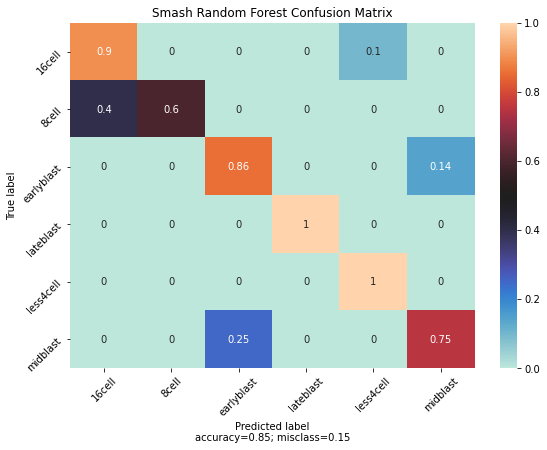

In [ ]:
plot_confusion_matrix(results[2], encoder.classes_, title = 'Smash Random Forest Confusion Matrix', save_path = viz_save_path + 'smash_rf_cm.png', cmap='icefire')

### Smash DNN

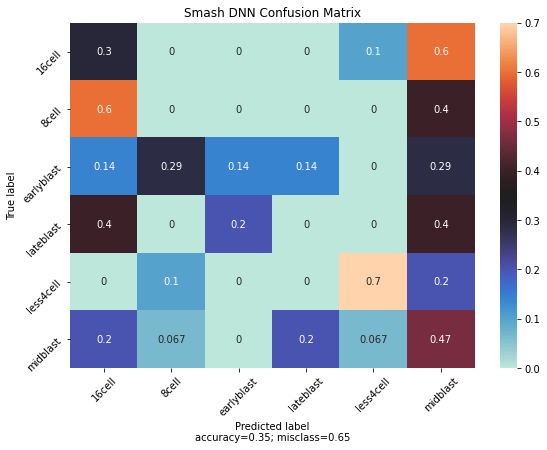

In [ ]:
results =  np.load(model_save_path + 'smash_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'Smash DNN Confusion Matrix', save_path = viz_save_path + 'smash_cm.png', cmap='icefire')

### RankCorr

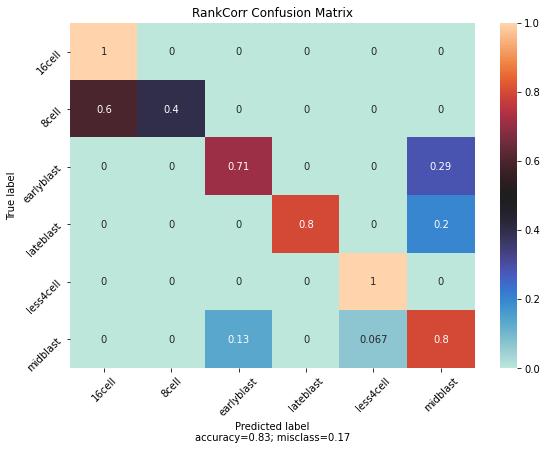

In [ ]:
results =  np.load(model_save_path + 'rankcorr_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'RankCorr Confusion Matrix', save_path = viz_save_path + 'rankcorr_cm.png', cmap='icefire')

### L1 VAE

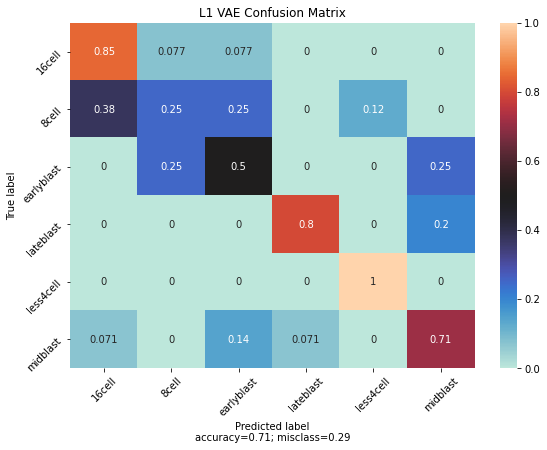

In [ ]:
results =  np.load(model_save_path + 'l1_vae_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'L1 VAE Confusion Matrix', save_path = viz_save_path + 'l1_vae_cm.png', cmap='icefire')

### Global Gate VAE

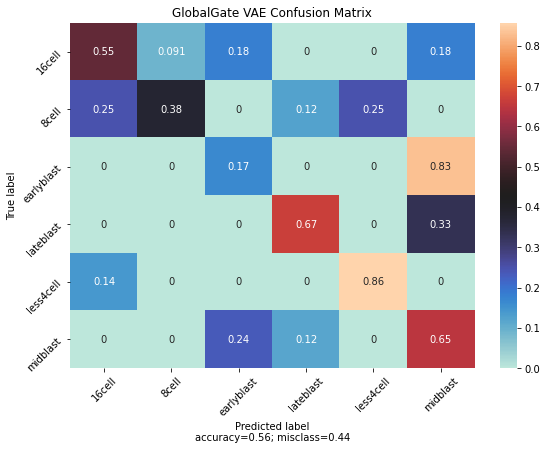

In [ ]:
results =  np.load(model_save_path + 'globalgate_vae_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'GlobalGate VAE Confusion Matrix', save_path = viz_save_path + 'globalgate_vae_cm.png', cmap='icefire')

### Running Gumbel VAE

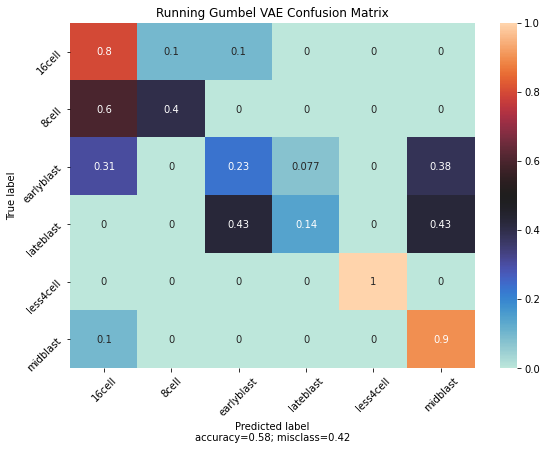

In [ ]:
results =  np.load(model_save_path + 'runningstate_vae_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'Running Gumbel VAE Confusion Matrix', save_path = viz_save_path + 'runningstate_vae_cm.png', cmap='icefire')

### Running Gumbel Classifier


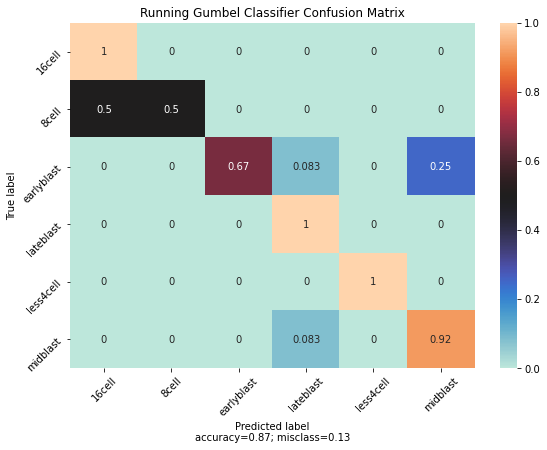

In [ ]:
results =  np.load(model_save_path + 'runningstate_classifier_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'Running Gumbel Classifier Confusion Matrix', save_path = viz_save_path + 'runningstate_classifier_cm.png', cmap='icefire')

### RunningState VAE+Classifier

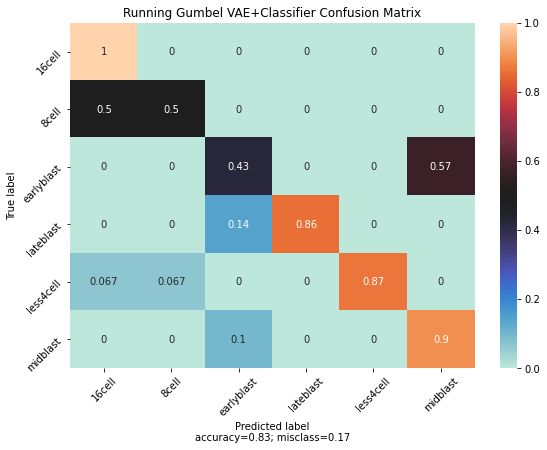

In [ ]:
results =  np.load(model_save_path + 'runningstate_vae+classifier_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'Running Gumbel VAE+Classifier Confusion Matrix', save_path = viz_save_path + 'runningstate_vae+classifier_cm.png', cmap = 'icefire')

### Concrete VAE

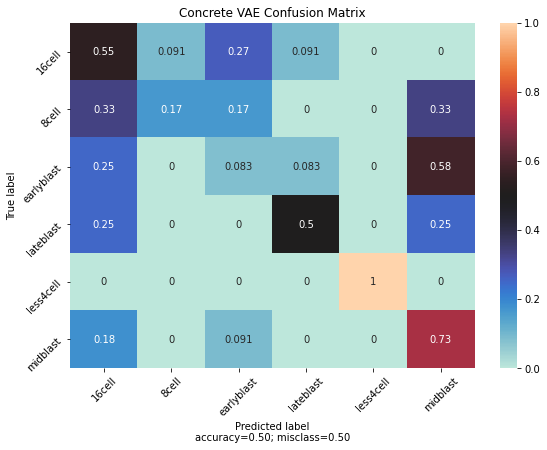

In [ ]:
results =  np.load(model_save_path + 'concrete_vae_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'Concrete VAE Confusion Matrix', save_path = viz_save_path + 'concrete_vae_cm.png', cmap='icefire')

## LassoNet

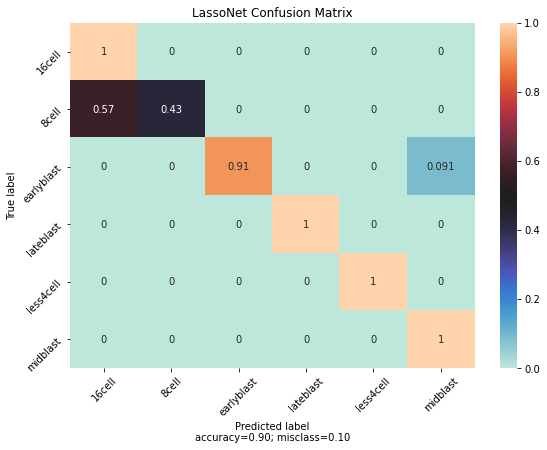

In [39]:
results =  np.load(model_save_path + 'lasso_net_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'LassoNet Confusion Matrix', save_path = viz_save_path + 'lasso_net_cm.png', cmap = 'icefire')

## UMap Visualization

In [40]:
import cv2

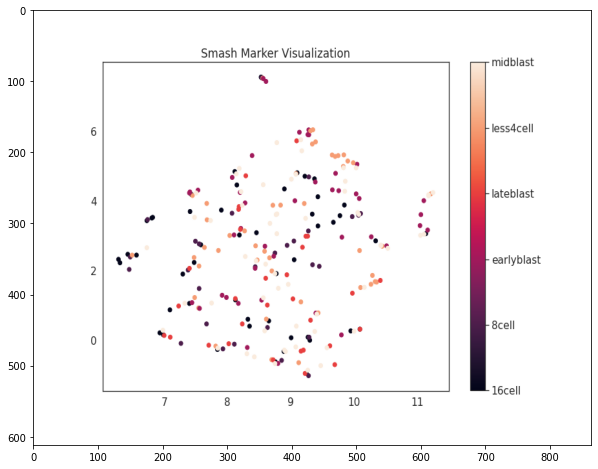

In [ ]:
img = cv2.imread(viz_save_path + 'smash_markers_1.png')
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(img[:,:, ::-1], aspect = 'auto')
plt.show()

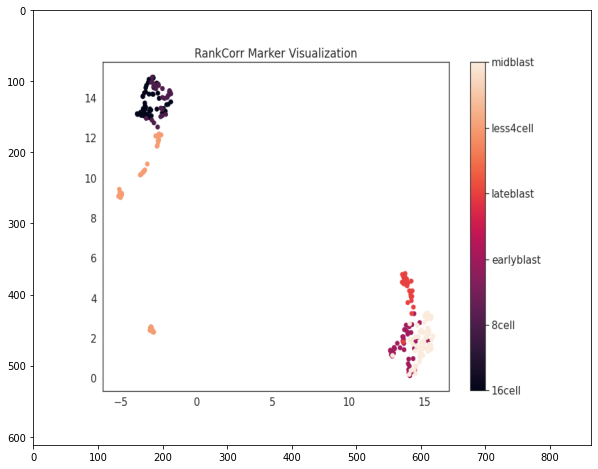

In [ ]:
img = cv2.imread(viz_save_path + 'rankcorr_markers_1.png')
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(img[:,:, ::-1], aspect = 'auto')

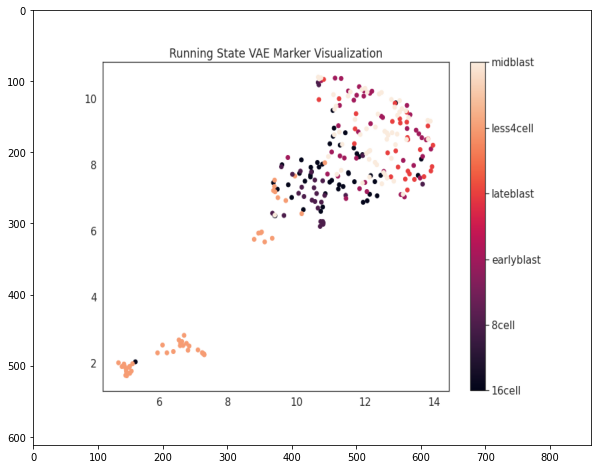

In [ ]:
img = cv2.imread(viz_save_path + 'runningstate_vae_markers_1.png')
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(img[:,:, ::-1], aspect = 'auto')
plt.show()

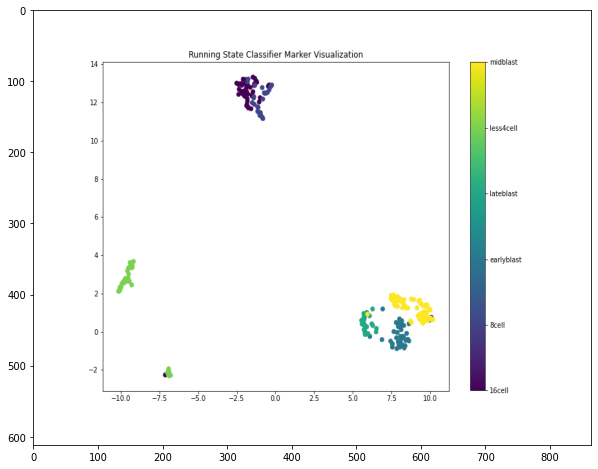

In [ ]:
img = cv2.imread(viz_save_path + 'runningstate_classifier_markers_1.png')
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(img[:,:, ::-1], aspect = 'auto')
plt.show()

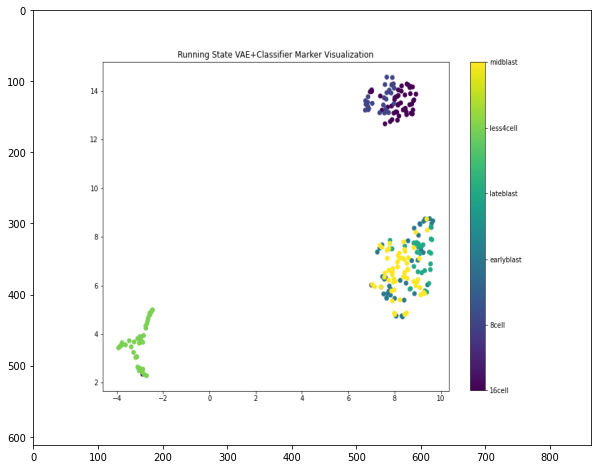

In [ ]:
img = cv2.imread(viz_save_path + 'runningstate_vae+classifier_markers_1.png')
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(img[:,:, ::-1], aspect = 'auto')
plt.show()

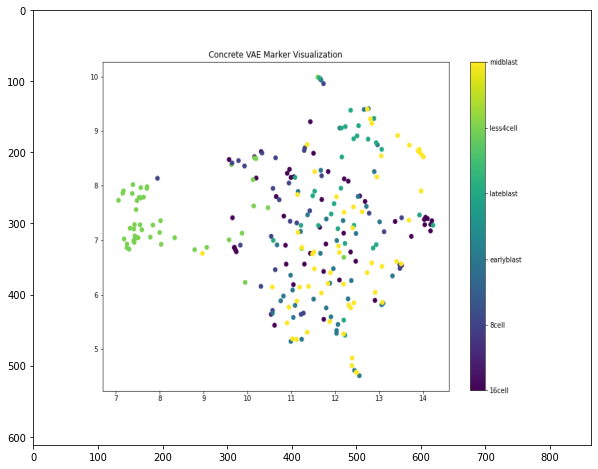

In [ ]:
img = cv2.imread(viz_save_path + 'concrete_vae_markers_1.png')
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(img[:,:, ::-1], aspect = 'auto')
plt.show()

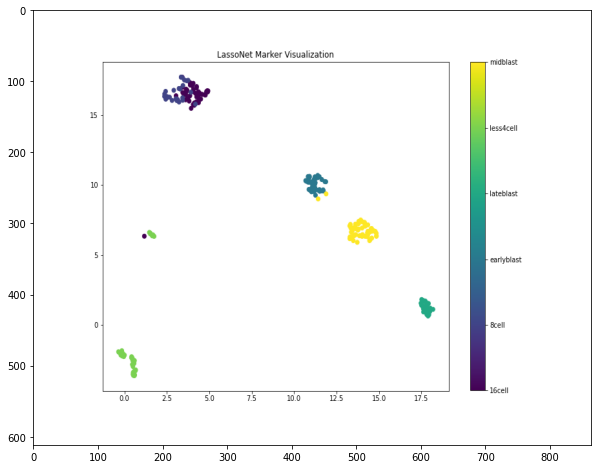

In [41]:
img = cv2.imread(viz_save_path + 'lasso_net_markers_1.png')
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(img[:,:, ::-1], aspect = 'auto')
plt.show()

## Visualizing Reconstructions

from first model of each

## L1 VAE

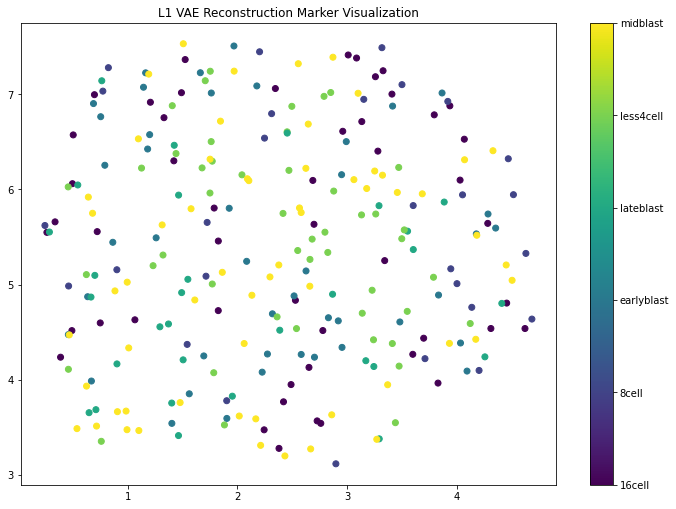

In [ ]:
model = load_model(VAE_l1_diag, model_save_path + 'l1_vae_{}.ckpt'.format(1))
l1_vae_markers = np.load(model_save_path + 'l1_vae_markers_{}.npy'.format(1), allow_pickle=True)
with torch.no_grad():
    recon_X = model(torch.tensor(X))[0]
visualize_save_embedding(recon_X.cpu(), y, encoder, 'L1 VAE Reconstruction Marker Visualization', path = viz_save_path + 'recon_l1_vae_{}.png'.format(1), markers = l1_vae_markers)

### Global Gate VAE

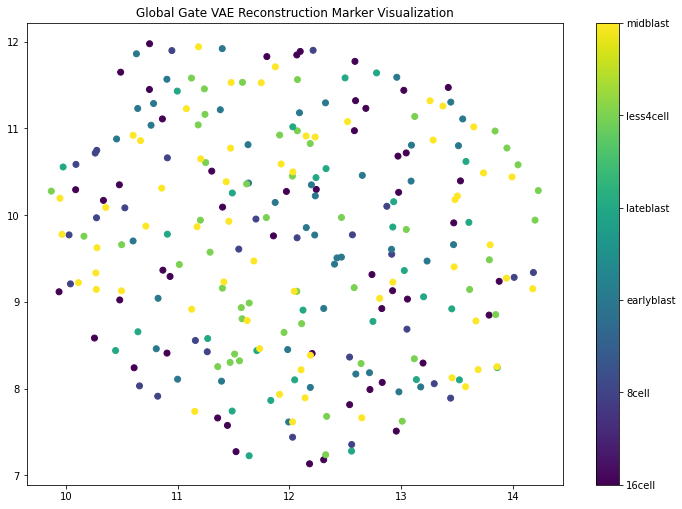

In [ ]:
model = load_model(VAE_Gumbel_GlobalGate, model_save_path + 'globalgate_vae_{}.ckpt'.format(1))
globalgate_vae_markers = np.load(model_save_path + 'globalgate_vae_markers_{}.npy'.format(1), allow_pickle=True)
with torch.no_grad():
    recon_X = model(torch.tensor(X))[0]
visualize_save_embedding(recon_X.cpu(), y, encoder, 'Global Gate VAE Reconstruction Marker Visualization', path = viz_save_path + 'recon_globalgate_vae_{}.png'.format(1), markers = globalgate_vae_markers)

### Running State Gumbel VAE

In [ ]:
model = load_model(VAE_Gumbel_RunningState, model_save_path + 'runningstate_vae_{}.ckpt'.format(1))


In [ ]:
runningstate_vae_markers = np.load(model_save_path + 'runningstate_vae_markers_{}.npy'.format(1), allow_pickle=True)

In [ ]:
with torch.no_grad():
    recon_X = model(torch.tensor(X))[0]

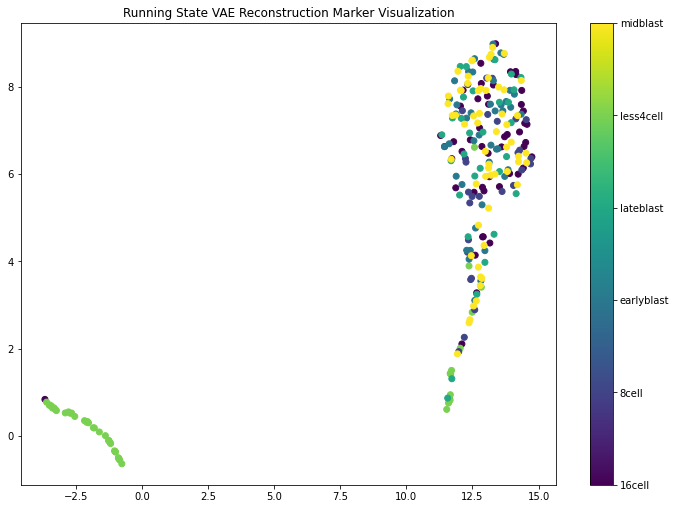

In [ ]:
visualize_save_embedding(recon_X.cpu(), y, encoder, 'Running State VAE Reconstruction Marker Visualization', path = viz_save_path + 'recon_runningstate_vae_{}.png'.format(1), markers = runningstate_vae_markers)

### RunningState VAE+Classifier

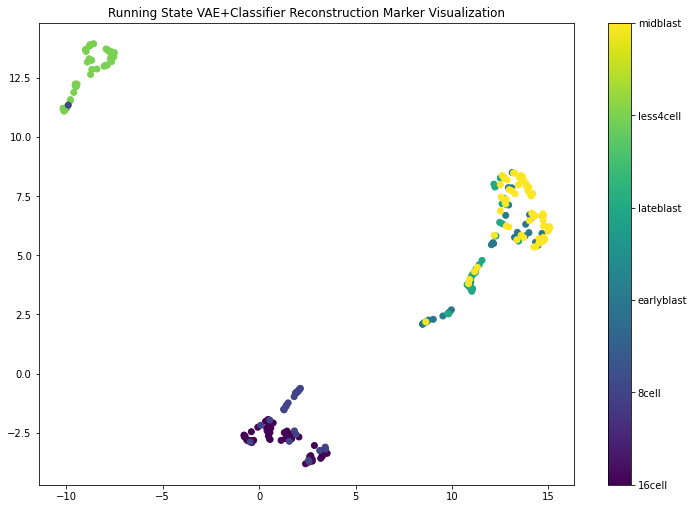

In [ ]:
model = load_model(RunningState_VAE_Classifier, model_save_path + 'runningstate_vae+classifier_{}.ckpt'.format(1))
runningstate_vae_classifier_markers = np.load(model_save_path + 'runningstate_vae+classifier_markers_{}.npy'.format(1), allow_pickle=True)
with torch.no_grad():
    recon_X = model(torch.tensor(X))[0]
visualize_save_embedding(recon_X.cpu(), y, encoder, 'Running State VAE+Classifier Reconstruction Marker Visualization', 
                         path = viz_save_path + 'recon_runningstate_vae+classifier_{}.png'.format(1), markers = runningstate_vae_classifier_markers)

Concrete VAE

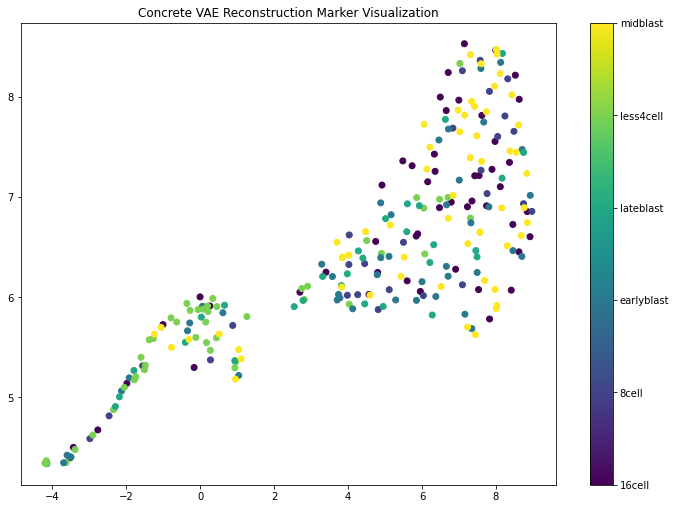

In [ ]:
model = load_model(ConcreteVAE_NMSL, model_save_path + 'concrete_vae_{}.ckpt'.format(1))
concrete_vae_markers = np.load(model_save_path + 'concrete_vae_markers_{}.npy'.format(1), allow_pickle=True)
with torch.no_grad():
    recon_X = model(torch.tensor(X))[0]
visualize_save_embedding(recon_X.cpu(), y, encoder, 'Concrete VAE Reconstruction Marker Visualization', path = viz_save_path + 'recon_concrete_vae_{}.png'.format(1), markers = concrete_vae_markers)

# Things to note for paper

PySmash uses a seed internally so the model is deterministic to a particular dataset. We used various different train seeds, whereas the smash paper uses the whole dataset for the data.

For smash DNN, to select the markers, I had to use all the data. Couldn't just use train and val set.